Computation of the Pascal triangle modulo some integer called 'base'.
If the integer is 2, this is also called the Sierpinski triangle.
The triangle is put in a square: what is usually a line is now a diagonal.

Usual Pascal triangle     

    1                         
    1 1                       
    1 2 1                     
    1 3 3 1                   
    1 4 6 4 1 

Pascal triangle in a square

    1 1 1 1 1
    1 2 3 4 5
    1 3 6 10
    1 4 10
    1 5 15

Two dimensional array s[][] such that
 - s[i][0] = s[O][i] = 1 for all i >= 0
 - s[i][j] = s[i-1][j] + s[i][j-1] mod base for all i,j >= 1

In [272]:
import matplotlib.pyplot as plt
import math
import itertools
import pandas as pd
import numpy as np
from scipy.stats import poisson
from scipy.stats import chisquare
from scipy.stats import mannwhitneyu
from scipy.stats import levene

In [3]:


BASE = 2

class PascalModulo:
    def __init__(self,base):
        self.base = base
        self.diags = [[1]]
        
    #Add a diagonal and fill it
    def _add(self):
        self.diags[0].append(1)
        i = 1
        while i <= len(self.diags) - 1:
            self.diags[i].append( (self.diags[i-1][len(self.diags[i])] + self.diags[i][len(self.diags[i]) - 1]) % self.base )
            i+=1
        self.diags.append([1])
            
    #Get element
    def get(self,i,j):
        if (i < 1 or j < 1):
            return 1
        # Compute diagonal if not computed yet
        while (len(self.diags[0]) <= i+j):
            self._add()
        return self.diags[i][j]
    
    
# sierp = PascalModulo(BASE)
# sierp.get(7,7)
# sierp.diags 

In [306]:
class Levin:
    
    def __init__(self,size=1):
        self.size = size
        self.iterator = itertools.product([False, True], repeat=self.size)
        self.block = next(self.iterator)
        self.block_index = 0
        self.sierp = PascalModulo(2)
    
    def get_next_digit(self):
#       print('block: ' + str(self.block) + ' ' + str(self.block_index))
        #check if the whole block was consumed and get a new one
        if len(self.block)  == self.block_index:
            try:
                self.block = next(self.iterator)
            except:
                self.size += 1
                self.iterator = itertools.product([False, True], repeat=self.size)
                self.block = next(self.iterator)
            self.block_index = 0
        res = 0
        for j in range(self.size):
            res += self.sierp.get(self.block_index,self.size-j-1) * self.block[j]
        self.block_index += 1
        return res%2
    
class Champernowne:
    def __init__(self,size=1):
        self.size = size
        self.iterator = itertools.product([False, True], repeat=self.size)
        self.block = next(self.iterator)
        self.block_index = 0
        
    def get_next_digit(self):
        #check if the whole block was consumed and get a new one
        if len(self.block)  == self.block_index:
            try:
                self.block = next(self.iterator)
            except:
                self.size += 1
                self.iterator = itertools.product([False, True], repeat=self.size)
                self.block = next(self.iterator)
            self.block_index = 0
        res = self.block[self.block_index]
        self.block_index += 1
        return res%2

In [ ]:
def get_occurrences(amounts,M):
    #returns frequency of occurencies for each value in the observed range
    occs = {}
    total = 0    
    for k,v in amounts.items():
        total += 1
        if v not in occs:
            occs[v] = 0
        occs[v] = occs[v] + 1
    occs[0] = int(2**M - total)
    max_o = 0
    for k,v in occs.items():
#         occs[k] = v/2**M
        occs[k] = v
        if k > max_o:
            max_o = k
    occs_array = [occs[i] if i in occs  else 0 for i in range(max_o+1)]
    return occs_array

In [279]:
def get_M(N,lamb):
    return int(math.ceil(math.log(N,2) - math.log(lamb,2)))

def normalize_data(occs, N, lamb):
    M = get_M(N,lamb)
    ret = []
    for o in occs:
        ret.append(o/2**M)
    return ret

def get_mean(normalized_occs):
    mean = 0
    for i in range(len(normalized_occs)):
        mean += i*normalized_occs[i]
    return mean

def get_std(normalized_occs,mean):
    if mean == None:
        mean = get_mean(normalized_occs)
        
    std = 0
    for i in range(len(normalized_occs)):
        std += ((i-mean)**2)*normalized_occs[i]
    return std

In [309]:
def get_amounts_for_ns(Ns,lamb=1,use_levin=True):
    if use_levin:
        sequence = Levin()
    else:
        sequence = Champernowne()
        
    Ms = [get_M(N,lamb) for N in Ns]
    
    min_M = min(Ms)
    max_M = max(Ms)
    max_N = max(Ns)
    
    #create dictionaries to store frequencies of every N value
    amounts = {}
    occurrences = {}
    for N in Ns:
        amounts[N] = {}    
    counter = 0
    word = ''
    
    #Get digits up to max M
    while len(word) < max_M:
        counter += 1
        word = word + str(sequence.get_next_digit())
    
    #process first big word
    for i in range(len(Ms)):
        M = Ms[i]
        N = Ns[i]
        for j in range(len(word) - M + 1):
            if counter < N :
                sub_word = word[j:M+j]
                if  sub_word not in amounts[N]:
                    amounts[N][sub_word] = 0
                amounts[N][sub_word] = amounts[N][sub_word] + 1
            elif N not in occurrences:
                #Ns[i] is done and not processed, process occurences and store
                occurrences[N] = get_occurrences(amounts[N],M)
    #process up to max
    while counter <= max_N:
        #get new big word
        word = word[1:]
        word = word + str(sequence.get_next_digit())
        
        #process for each M
        for i in range(len(Ms)):
            M = Ms[i]
            N = Ns[i]
            if counter < N:
                sub_word = word[len(word) - M:]
                if  sub_word not in amounts[N]:
                    amounts[N][sub_word] = 0
                amounts[N][sub_word] = amounts[N][sub_word] + 1
            else:
                if N not in occurrences:
                    #N[i] is done and not processed, process occurences and store
                    occurrences[N] = get_occurrences(amounts[N],M)
        counter += 1
            
    return occurrences

In [74]:
def get_amounts_for_first(N,lamb=1):
    get_amounts_for_ns([N],lamb)

In [301]:
def analize_result(occs,N,l=1,plot=True):
    print("---- Normalized data ----")
    actual = np.array(normalize_data(occs,N,l))
    M = int(math.ceil(math.log(N,2)))    
    x= np.arange(0,len(actual),1)
    p = poisson.pmf(x,l)
    mean = get_mean(actual)
    std = get_std(actual,mean)
    print ("Mean: "+ str(mean) + "; expected: " + str(l) + "; difference: " + str(abs(l-mean)))
    print ("Std: "+ str(std) + "; expected: " + str(l) + "; difference: " + str(abs(l-std)))
    print("difference between std and mean :"+  str(abs(mean-std)))
    print("MWU: " + str(mannwhitneyu(actual,p)))
    print("Levene: " + str(levene(actual,p)))
    if(plot):
        plt.figure(l)
        plt.plot(x, p)
        p2 = plt.bar(x-0.5, p,label="expected",width=0.5)
        p1 = plt.bar(x, actual, color='#d62728',label="actual",width=0.5)
        plt.legend(loc='best')
        plt.show()
#         plt.figure(l+1)
#         stats.probplot(actual, dist='poisson', sparams=(l), plot=plt)
#         plt.show()

def analize_result_2(occs,l=1,plot=True):
    print("---- Sample data ----")
    actual = np.array(occs)
    sample = poisson.rvs(1, size=sum(occs))
    expected = [0 for i in range(max(max(sample)+1,len(actual)))]
    for i in sample:
        expected[i] += 1
    expected = np.array(expected)
    x= np.arange(0,len(actual),l)
#     print("chisquare: " + str(chisquare(f_obs=actual, f_exp=expected)))
    print("MWU: " + str(mannwhitneyu(actual,expected)))
    print("Levene: " + str(levene(actual,expected)))
    
    data_by_index = []
    for i in range(len(occs)):
        for j in range(occs[i]):
            data_by_index.append(i)
    
    if(plot):
#         plt.figure(l)
#         plt.plot(x, expected)
#         p2 = plt.bar(x-0.5, expected,label="expected",width=0.5)
#         p1 = plt.bar(x, actual, color='#d62728',label="actual",width=0.5)
#         plt.legend(loc='best')
#         plt.show()
        plt.figure(l+1)
        stats.probplot(data_by_index, dist='poisson', sparams=(l), plot=plt)
        plt.show()
    

### Computing with lambda = 1 from N=2ˆ10 up to 2ˆ26.

In [240]:
Ns = [2**i for i in range(10,26)]
occs = get_amounts_for_ns(Ns)

1024
---- Normalized data ----
Mean: 0.9912109375; expected: 1; difference: 0.0087890625
Std: 1.088789939880371; expected: 1; difference: 0.0887899398803711
difference between std and mean :0.0975790023803711
MWU: MannwhitneyuResult(statistic=18.0, pvalue=0.46803733853330987)
Levene: LeveneResult(statistic=0.0004228382363962327, pvalue=0.9839987450350745)


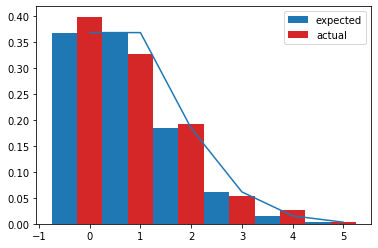

---- Sample data ----
MWU: MannwhitneyuResult(statistic=18.0, pvalue=0.4680931467365297)
Levene: LeveneResult(statistic=0.0026177689246286873, pvalue=0.960202309891221)


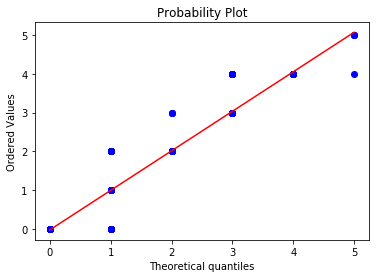

2048
---- Normalized data ----
Mean: 0.9951171875; expected: 1; difference: 0.0048828125
Std: 1.0800542831420898; expected: 1; difference: 0.08005428314208984
difference between std and mean :0.08493709564208984
MWU: MannwhitneyuResult(statistic=23.0, pvalue=0.4491077413427273)
Levene: LeveneResult(statistic=0.00015861176692122316, pvalue=0.9901585767339428)


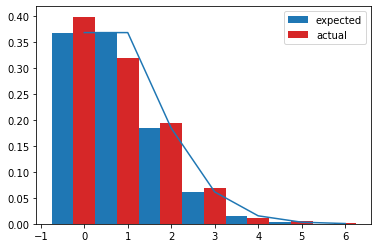

---- Sample data ----
MWU: MannwhitneyuResult(statistic=23.0, pvalue=0.4491633936346191)
Levene: LeveneResult(statistic=0.000900554896013226, pvalue=0.9765530081793911)


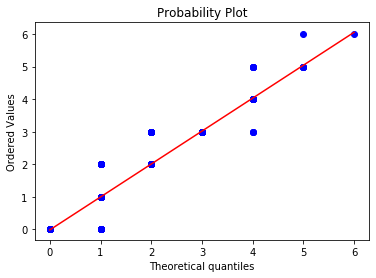

4096
---- Normalized data ----
Mean: 0.997314453125; expected: 1; difference: 0.002685546875
Std: 1.4533619284629822; expected: 1; difference: 0.4533619284629822
difference between std and mean :0.4560474753379822
MWU: MannwhitneyuResult(statistic=36.0, pvalue=0.36189765707468813)
Levene: LeveneResult(statistic=0.004771591263543373, pvalue=0.9457845063790485)


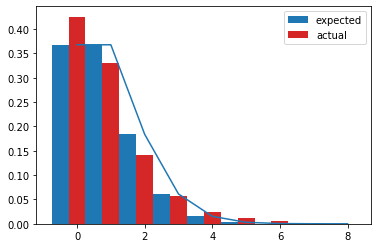

---- Sample data ----
MWU: MannwhitneyuResult(statistic=35.0, pvalue=0.3293391219268744)
Levene: LeveneResult(statistic=0.005058229527530055, pvalue=0.944182672325159)


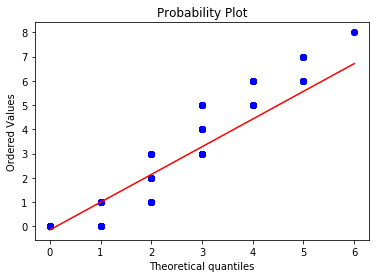

8192
---- Normalized data ----
Mean: 0.99853515625; expected: 1; difference: 0.00146484375
Std: 1.653562307357788; expected: 1; difference: 0.6535623073577881
difference between std and mean :0.6550271511077881
MWU: MannwhitneyuResult(statistic=41.0, pvalue=0.2601830104482655)
Levene: LeveneResult(statistic=0.006071827878453775, pvalue=0.9387498232568967)


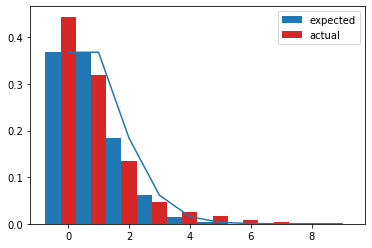

---- Sample data ----
MWU: MannwhitneyuResult(statistic=41.0, pvalue=0.2599472581779684)
Levene: LeveneResult(statistic=0.005653179349584034, pvalue=0.9408947639821899)


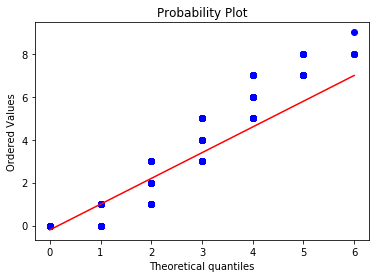

16384
---- Normalized data ----
Mean: 0.99920654296875; expected: 1; difference: 0.00079345703125
Std: 1.6763299368321896; expected: 1; difference: 0.6763299368321896
difference between std and mean :0.6771233938634396
MWU: MannwhitneyuResult(statistic=62.0, pvalue=0.12953519666662766)
Levene: LeveneResult(statistic=0.0004172079154968353, pvalue=0.9838726771181048)


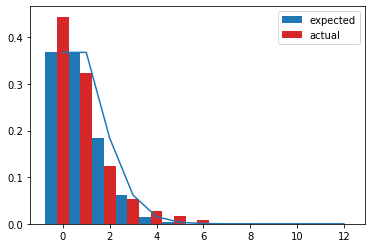

---- Sample data ----
MWU: MannwhitneyuResult(statistic=61.5, pvalue=0.12338916674958739)
Levene: LeveneResult(statistic=0.00043143027718795, pvalue=0.983600135909863)


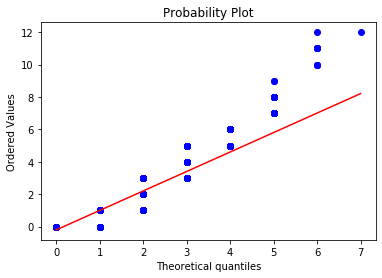

32768
---- Normalized data ----
Mean: 0.99957275390625; expected: 1; difference: 0.00042724609375
Std: 1.7086179815232754; expected: 1; difference: 0.7086179815232754
difference between std and mean :0.7090452276170254
MWU: MannwhitneyuResult(statistic=94.0, pvalue=0.10330788479137654)
Levene: LeveneResult(statistic=1.4507775200259583e-05, pvalue=0.9969861548562161)


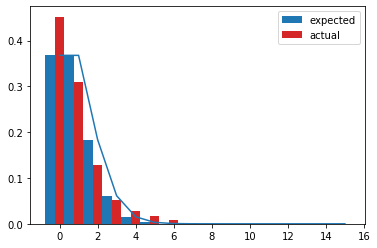

---- Sample data ----
MWU: MannwhitneyuResult(statistic=90.0, pvalue=0.07644378150913428)
Levene: LeveneResult(statistic=1.4768241868685592e-05, pvalue=0.9969592206748553)


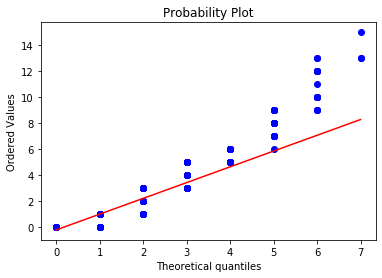

65536
---- Normalized data ----
Mean: 0.9997711181640625; expected: 1; difference: 0.0002288818359375
Std: 1.7924956751521677; expected: 1; difference: 0.7924956751521677
difference between std and mean :0.7927245569881052
MWU: MannwhitneyuResult(statistic=111.0, pvalue=0.05501505396695189)
Levene: LeveneResult(statistic=4.914140055343193e-06, pvalue=0.9982442180563779)


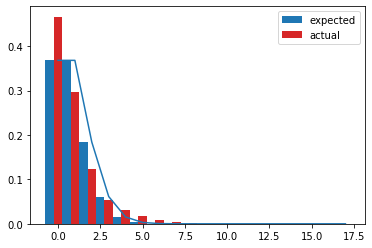

---- Sample data ----
MWU: MannwhitneyuResult(statistic=107.5, pvalue=0.042040139962551085)
Levene: LeveneResult(statistic=4.927649485484112e-06, pvalue=0.9982418063126194)


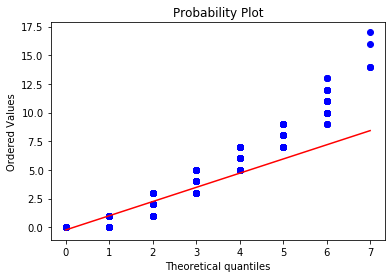

131072
---- Normalized data ----
Mean: 0.9998779296875; expected: 1; difference: 0.0001220703125
Std: 1.9096526950597763; expected: 1; difference: 0.9096526950597763
difference between std and mean :0.9097747653722763
MWU: MannwhitneyuResult(statistic=111.0, pvalue=0.02196446760514372)
Levene: LeveneResult(statistic=5.107163186348576e-06, pvalue=0.99820933641301)


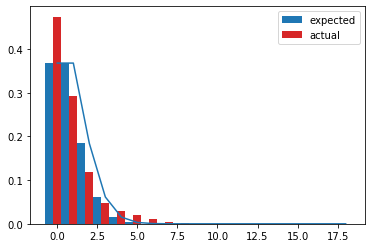

---- Sample data ----
MWU: MannwhitneyuResult(statistic=109.0, pvalue=0.01793176870746425)
Levene: LeveneResult(statistic=5.115593625332899e-06, pvalue=0.9982078590923148)


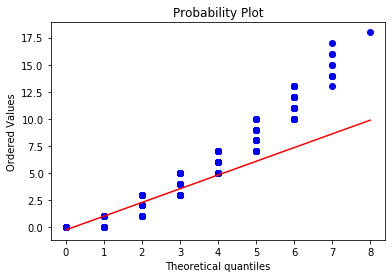

262144
---- Normalized data ----
Mean: 0.9999351501464844; expected: 1; difference: 6.4849853515625e-05
Std: 2.090930934515199; expected: 1; difference: 1.0909309345151992
difference between std and mean :1.0909957843687148
MWU: MannwhitneyuResult(statistic=127.0, pvalue=0.009650304089253232)
Levene: LeveneResult(statistic=4.240832706423378e-06, pvalue=0.9983671313186832)


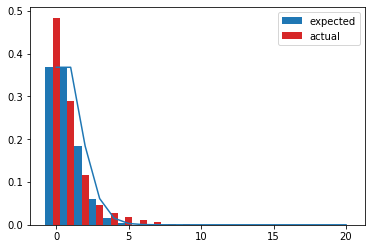

---- Sample data ----
MWU: MannwhitneyuResult(statistic=124.0, pvalue=0.007113587015417199)
Levene: LeveneResult(statistic=4.235796045278563e-06, pvalue=0.9983681012505425)


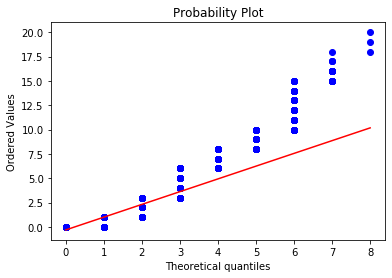

524288
---- Normalized data ----
Mean: 0.9999656677246094; expected: 1; difference: 3.4332275390625e-05
Std: 2.2523803699150444; expected: 1; difference: 1.2523803699150444
difference between std and mean :1.252414702190435
MWU: MannwhitneyuResult(statistic=133.0, pvalue=0.005434700476586038)
Levene: LeveneResult(statistic=1.5253300233205283e-06, pvalue=0.9990204265286203)


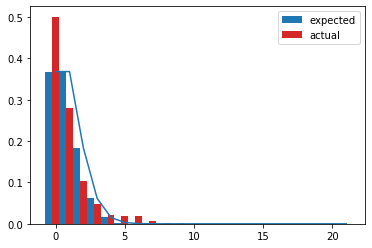

---- Sample data ----
MWU: MannwhitneyuResult(statistic=136.0, pvalue=0.0061767668254195255)
Levene: LeveneResult(statistic=1.5252402595492099e-06, pvalue=0.9990204553516515)


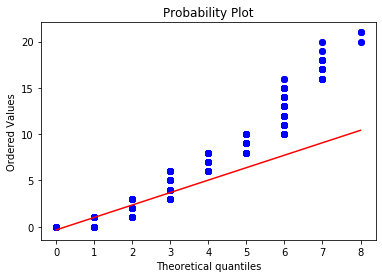

1048576
---- Normalized data ----
Mean: 0.9999818801879883; expected: 1; difference: 1.811981201171875e-05
Std: 2.389916419654582; expected: 1; difference: 1.3899164196545821
difference between std and mean :1.3899345394665938
MWU: MannwhitneyuResult(statistic=197.0, pvalue=0.001931078555013984)
Levene: LeveneResult(statistic=3.2464562198427027e-07, pvalue=0.9995475641749737)


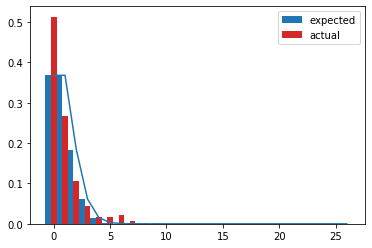

---- Sample data ----
MWU: MannwhitneyuResult(statistic=183.5, pvalue=0.0007042290906213623)
Levene: LeveneResult(statistic=3.247184465943701e-07, pvalue=0.9995475134299017)


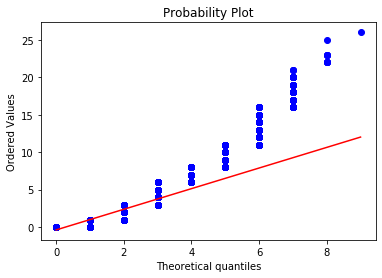

2097152
---- Normalized data ----
Mean: 0.9999904632568359; expected: 1; difference: 9.5367431640625e-06
Std: 2.8316497801824894; expected: 1; difference: 1.8316497801824894
difference between std and mean :1.8316593169256534
MWU: MannwhitneyuResult(statistic=243.0, pvalue=0.0011322502805564737)
Levene: LeveneResult(statistic=2.6025465794149795e-07, pvalue=0.9995947085567988)


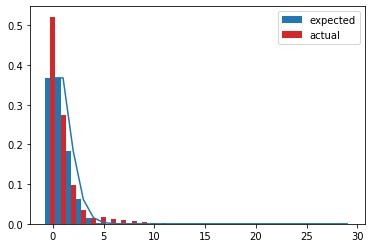

---- Sample data ----
MWU: MannwhitneyuResult(statistic=223.0, pvalue=0.00029700514156934374)
Levene: LeveneResult(statistic=2.603311574519204e-07, pvalue=0.9995946490008585)


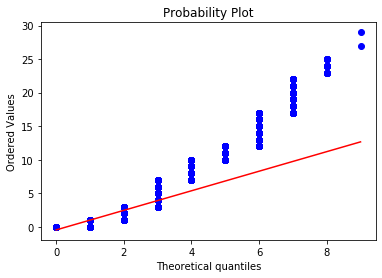

4194304
---- Normalized data ----
Mean: 0.9999949932098389; expected: 1; difference: 5.0067901611328125e-06
Std: 3.2049806117760795; expected: 1; difference: 2.2049806117760795
difference between std and mean :2.2049856185662406
MWU: MannwhitneyuResult(statistic=218.0, pvalue=4.0578098443537e-05)
Levene: LeveneResult(statistic=2.4769061167917416e-07, pvalue=0.9996045025332159)


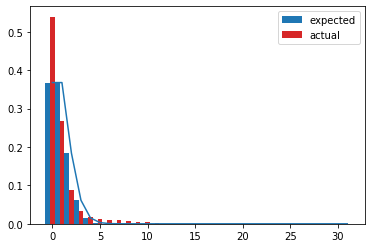

---- Sample data ----
MWU: MannwhitneyuResult(statistic=219.5, pvalue=3.276413900755645e-05)
Levene: LeveneResult(statistic=2.4770934387573655e-07, pvalue=0.9996044875802832)


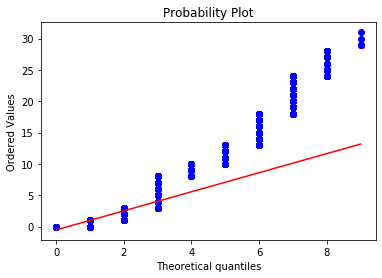

8388608
---- Normalized data ----
Mean: 0.9999973773956299; expected: 1; difference: 2.6226043701171875e-06
Std: 3.2432062625816225; expected: 1; difference: 2.2432062625816225
difference between std and mean :2.2432088851859926
MWU: MannwhitneyuResult(statistic=243.0, pvalue=7.307187427838922e-06)
Levene: LeveneResult(statistic=1.6384609864396004e-07, pvalue=0.9996782181958629)


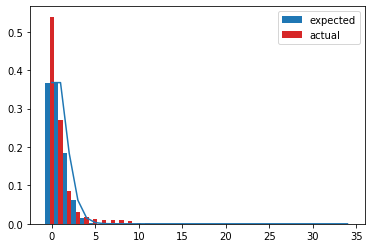

---- Sample data ----
MWU: MannwhitneyuResult(statistic=244.0, pvalue=4.834476997668592e-06)
Levene: LeveneResult(statistic=1.6385166720824216e-07, pvalue=0.9996782127248569)


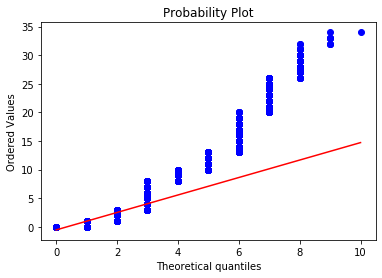

16777216
---- Normalized data ----
Mean: 0.9999986290931702; expected: 1; difference: 1.3709068298339844e-06
Std: 3.267494261262921; expected: 1; difference: 2.267494261262921
difference between std and mean :2.267495632169751
MWU: MannwhitneyuResult(statistic=304.0, pvalue=3.3312412225741657e-07)
Levene: LeveneResult(statistic=3.398543002521782e-08, pvalue=0.9998533678188493)


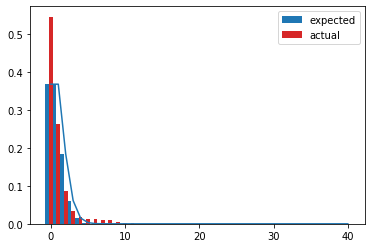

---- Sample data ----
MWU: MannwhitneyuResult(statistic=304.0, pvalue=1.723281850739646e-07)
Levene: LeveneResult(statistic=3.39851675453783e-08, pvalue=0.9998533683745047)


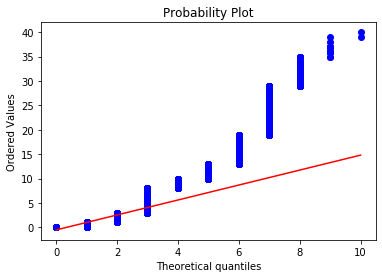

33554432
---- Normalized data ----
Mean: 0.9999992847442627; expected: 1; difference: 7.152557373046875e-07
Std: 3.3934298753733283; expected: 1; difference: 2.3934298753733283
difference between std and mean :2.3934305906290656
MWU: MannwhitneyuResult(statistic=364.0, pvalue=1.0970978184854034e-08)
Levene: LeveneResult(statistic=1.2188441247364735e-08, pvalue=0.9999121515776166)


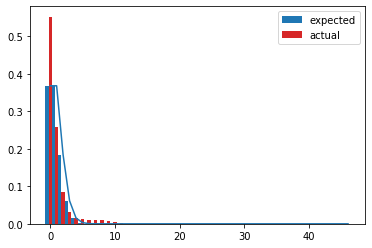

---- Sample data ----
MWU: MannwhitneyuResult(statistic=358.0, pvalue=2.9161148417058448e-09)
Levene: LeveneResult(statistic=1.2188213614221197e-08, pvalue=0.9999121523874183)


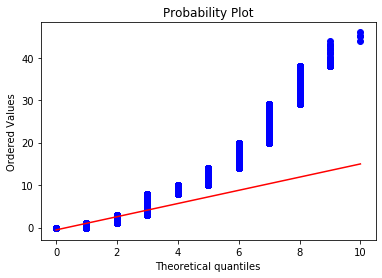

In [302]:
for N in Ns:
    print(N)
    analize_result(occs[N],N,plot=True)
    analize_result_2(occs[N],plot=True)

### Computing with lambda = 4 from N=2ˆ10 up to 2ˆ26.

In [247]:
Ns2 = [2**i for i in range(10,26)]
occs2 = get_amounts_for_ns(Ns2,lamb=4)

1024
---- Normalized data ----
Mean: 3.97265625; expected: 4; difference: 0.02734375
Std: 4.6437835693359375; expected: 4; difference: 0.6437835693359375
difference between std and mean :0.6711273193359375
MWU: MannwhitneyuResult(statistic=72.0, pvalue=0.48847761269707995)
Levene: LeveneResult(statistic=0.327983841646747, pvalue=0.5726558592047031)


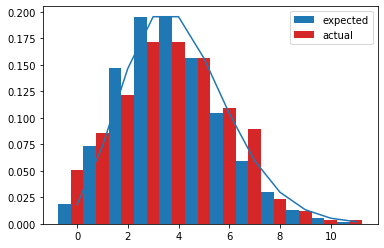

---- Sample data ----
MWU: MannwhitneyuResult(statistic=38.0, pvalue=0.024343081840110616)
Levene: LeveneResult(statistic=0.44909220706554237, pvalue=0.5097401909525054)


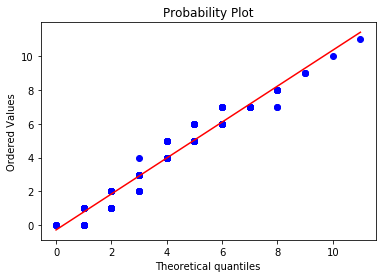

2048
---- Normalized data ----
Mean: 3.984375; expected: 4; difference: 0.015625
Std: 4.175537109375; expected: 4; difference: 0.175537109375
difference between std and mean :0.191162109375
MWU: MannwhitneyuResult(statistic=71.0, pvalue=0.48848262430702205)
Levene: LeveneResult(statistic=0.01629730908047247, pvalue=0.8995770539529728)


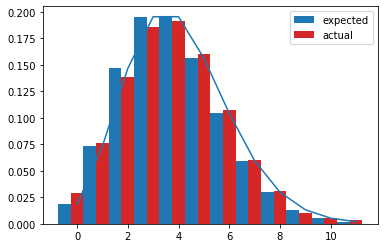

---- Sample data ----
MWU: MannwhitneyuResult(statistic=43.5, pvalue=0.05161601047428278)
Levene: LeveneResult(statistic=0.3058439886724447, pvalue=0.5858181708527694)


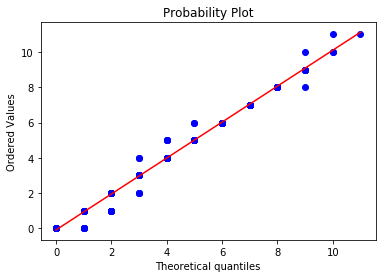

4096
---- Normalized data ----
Mean: 3.9912109375; expected: 4; difference: 0.0087890625
Std: 5.420821189880371; expected: 4; difference: 1.420821189880371
difference between std and mean :1.429610252380371
MWU: MannwhitneyuResult(statistic=79.0, pvalue=0.39880010979147085)
Levene: LeveneResult(statistic=0.3283053871395948, pvalue=0.5719884876879613)


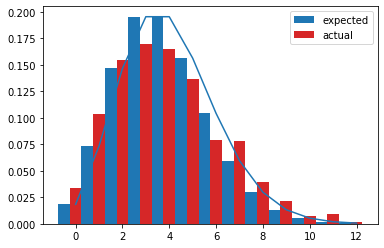

---- Sample data ----
MWU: MannwhitneyuResult(statistic=50.5, pvalue=0.0413760359942225)
Levene: LeveneResult(statistic=0.3542147543389587, pvalue=0.5573075473825496)


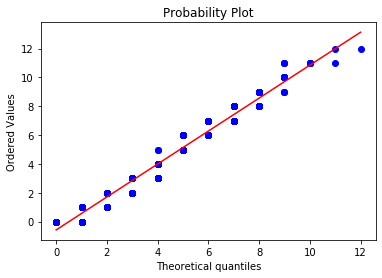

8192
---- Normalized data ----
Mean: 3.9951171875; expected: 4; difference: 0.0048828125
Std: 6.01169490814209; expected: 4; difference: 2.01169490814209
difference between std and mean :2.01657772064209
MWU: MannwhitneyuResult(statistic=91.0, pvalue=0.3825841746929821)
Levene: LeveneResult(statistic=0.36363397254691215, pvalue=0.5517192992964484)


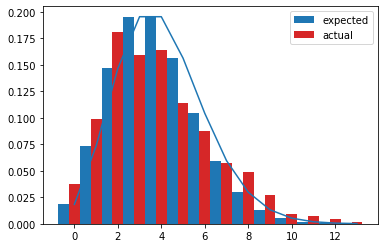

---- Sample data ----
MWU: MannwhitneyuResult(statistic=55.0, pvalue=0.02453894205354802)
Levene: LeveneResult(statistic=0.2867930900174141, pvalue=0.5968345802966912)


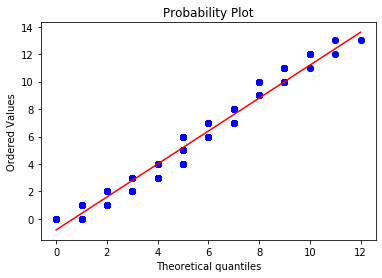

16384
---- Normalized data ----
Mean: 3.997314453125; expected: 4; difference: 0.002685546875
Std: 6.552971303462982; expected: 4; difference: 2.552971303462982
difference between std and mean :2.555656850337982
MWU: MannwhitneyuResult(statistic=140.0, pvalue=0.24816559526272136)
Levene: LeveneResult(statistic=0.0334727272006722, pvalue=0.8559195399670076)


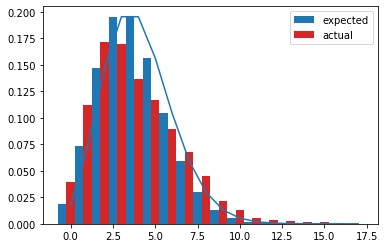

---- Sample data ----
MWU: MannwhitneyuResult(statistic=79.0, pvalue=0.003911781760526553)
Levene: LeveneResult(statistic=0.034450076839368515, pvalue=0.8538555950331881)


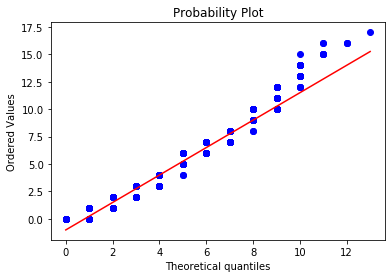

32768
---- Normalized data ----
Mean: 3.99853515625; expected: 4; difference: 0.00146484375
Std: 6.710447072982788; expected: 4; difference: 2.710447072982788
difference between std and mean :2.711911916732788
MWU: MannwhitneyuResult(statistic=181.0, pvalue=0.16322914811684786)
Levene: LeveneResult(statistic=0.007423932282611145, pvalue=0.9317673060743435)


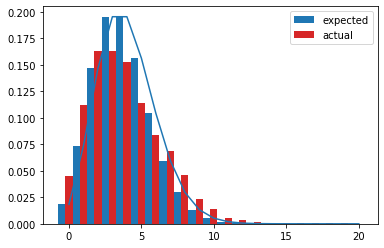

---- Sample data ----
MWU: MannwhitneyuResult(statistic=97.5, pvalue=0.0008428183653569292)
Levene: LeveneResult(statistic=0.005854695318871783, pvalue=0.93939004320189)


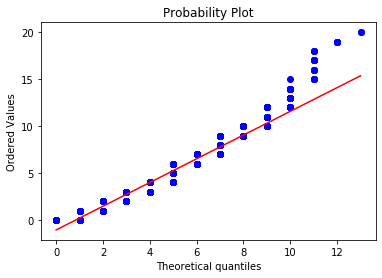

65536
---- Normalized data ----
Mean: 3.99920654296875; expected: 4; difference: 0.00079345703125
Std: 7.15130552276969; expected: 4; difference: 3.1513055227696896
difference between std and mean :3.1520989798009396
MWU: MannwhitneyuResult(statistic=236.0, pvalue=0.07013877596045084)
Levene: LeveneResult(statistic=0.0015973110399356849, pvalue=0.968285708815182)


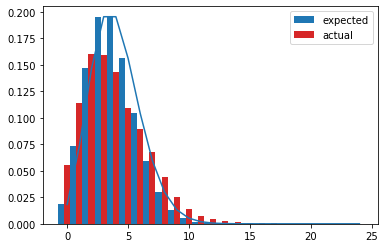

---- Sample data ----
MWU: MannwhitneyuResult(statistic=129.5, pvalue=0.00015125854809649292)
Levene: LeveneResult(statistic=0.000928042596762408, pvalue=0.9758234870641166)


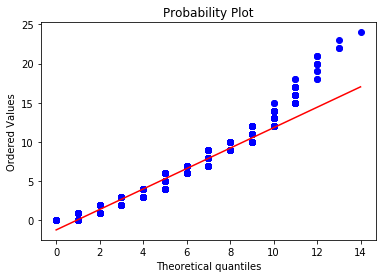

131072
---- Normalized data ----
Mean: 3.99957275390625; expected: 4; difference: 0.00042724609375
Std: 7.796081360429525; expected: 4; difference: 3.7960813604295254
difference between std and mean :3.7965086065232754
MWU: MannwhitneyuResult(statistic=280.0, pvalue=0.07306132592251174)
Levene: LeveneResult(statistic=0.0009283416111118242, pvalue=0.9758099001289736)


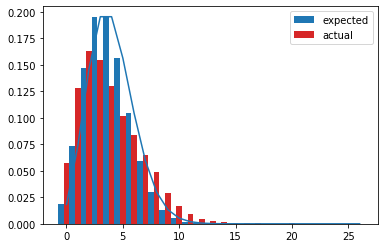

---- Sample data ----
MWU: MannwhitneyuResult(statistic=156.0, pvalue=0.00011657115970219494)
Levene: LeveneResult(statistic=0.0005063670536528588, pvalue=0.9821331660654553)


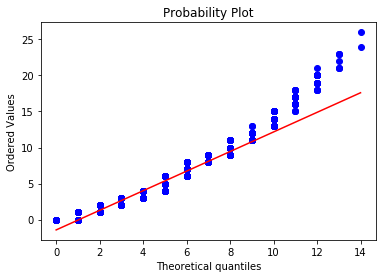

262144
---- Normalized data ----
Mean: 3.9997711181640625; expected: 4; difference: 0.0002288818359375
Std: 8.595779366558418; expected: 4; difference: 4.595779366558418
difference between std and mean :4.596008248394355
MWU: MannwhitneyuResult(statistic=335.0, pvalue=0.04523622461013404)
Levene: LeveneResult(statistic=0.00047624589776486297, pvalue=0.9826640057532796)


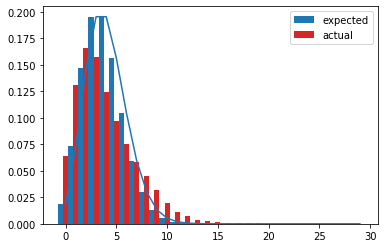

---- Sample data ----
MWU: MannwhitneyuResult(statistic=189.0, pvalue=3.675857295192563e-05)
Levene: LeveneResult(statistic=0.0002529614129042437, pvalue=0.987364957441672)


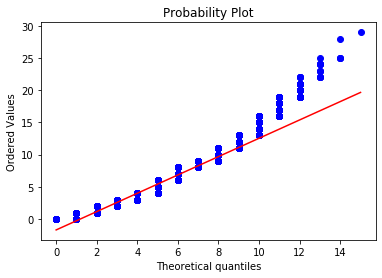

524288
---- Normalized data ----
Mean: 3.9998779296875; expected: 4; difference: 0.0001220703125
Std: 9.379974350333214; expected: 4; difference: 5.379974350333214
difference between std and mean :5.380096420645714
MWU: MannwhitneyuResult(statistic=356.0, pvalue=0.018397025770230738)
Levene: LeveneResult(statistic=0.0002600527018985562, pvalue=0.9871855341317218)


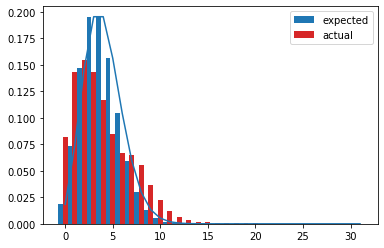

---- Sample data ----
MWU: MannwhitneyuResult(statistic=195.5, pvalue=6.517570104231694e-06)
Levene: LeveneResult(statistic=0.0001378402695819078, pvalue=0.9906703174057327)


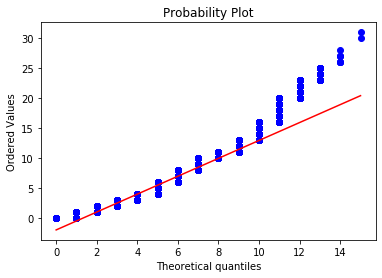

1048576
---- Normalized data ----
Mean: 3.9999351501464844; expected: 4; difference: 6.4849853515625e-05
Std: 9.749706264105042; expected: 4; difference: 5.749706264105042
difference between std and mean :5.749771113958557
MWU: MannwhitneyuResult(statistic=438.0, pvalue=0.009147756996618791)
Levene: LeveneResult(statistic=7.800057671880956e-05, pvalue=0.9929784621235029)


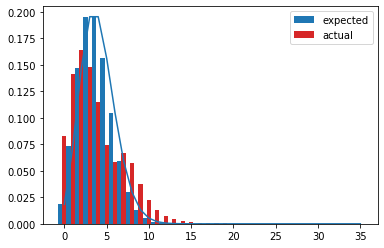

---- Sample data ----
MWU: MannwhitneyuResult(statistic=244.5, pvalue=1.3346413290221673e-06)
Levene: LeveneResult(statistic=4.223658205591978e-05, pvalue=0.9948330965678728)


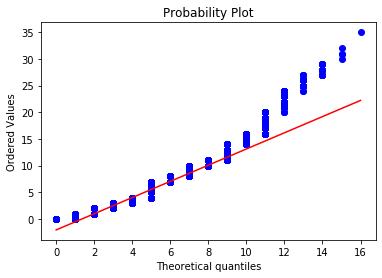

2097152
---- Normalized data ----
Mean: 3.9999656677246094; expected: 4; difference: 3.4332275390625e-05
Std: 11.255565642131844; expected: 4; difference: 7.2555656421318435
difference between std and mean :7.255599974407234
MWU: MannwhitneyuResult(statistic=374.0, pvalue=0.0025900225820523807)
Levene: LeveneResult(statistic=0.00025625808247218526, pvalue=0.9872748352673311)


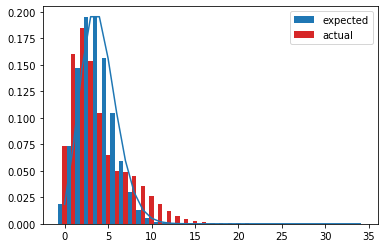

---- Sample data ----
MWU: MannwhitneyuResult(statistic=202.0, pvalue=3.8245240884436716e-07)
Levene: LeveneResult(statistic=0.00013965408873498186, pvalue=0.9906057953107278)


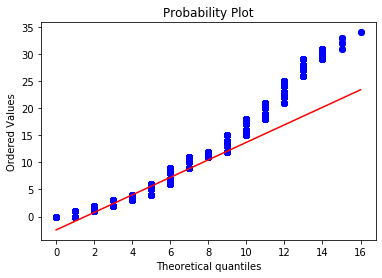

4194304
---- Normalized data ----
Mean: 3.9999818801879883; expected: 4; difference: 1.811981201171875e-05
Std: 12.630023002296188; expected: 4; difference: 8.630023002296188
difference between std and mean :8.6300411221082
MWU: MannwhitneyuResult(statistic=449.0, pvalue=0.00037213806020204235)
Levene: LeveneResult(statistic=9.388791724216553e-05, pvalue=0.9922936966644915)


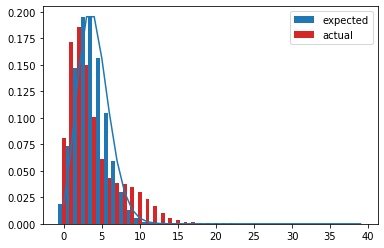

---- Sample data ----
MWU: MannwhitneyuResult(statistic=242.0, pvalue=1.7758901385353462e-08)
Levene: LeveneResult(statistic=5.224293837020388e-05, pvalue=0.994251452848497)


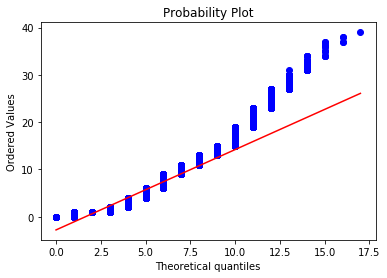

8388608
---- Normalized data ----
Mean: 3.999990463256836; expected: 4; difference: 9.5367431640625e-06
Std: 12.872947692780144; expected: 4; difference: 8.872947692780144
difference between std and mean :8.872957229523308
MWU: MannwhitneyuResult(statistic=511.0, pvalue=6.957572736973741e-05)
Levene: LeveneResult(statistic=5.518898128109315e-05, pvalue=0.9940898329869352)


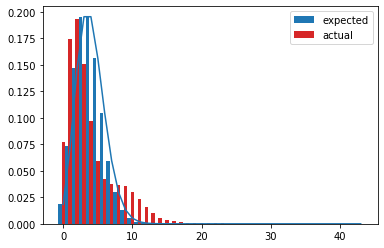

---- Sample data ----
MWU: MannwhitneyuResult(statistic=274.5, pvalue=1.279975247760713e-09)
Levene: LeveneResult(statistic=3.115318640698145e-05, pvalue=0.9955595543195428)


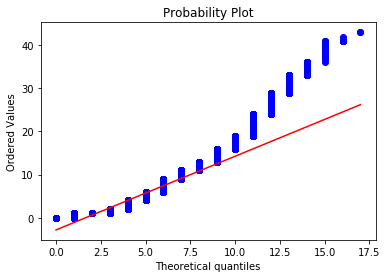

16777216
---- Normalized data ----
Mean: 3.999994993209839; expected: 4; difference: 5.0067901611328125e-06
Std: 12.94379973409053; expected: 4; difference: 8.94379973409053
difference between std and mean :8.943804740880692
MWU: MannwhitneyuResult(statistic=645.0, pvalue=1.5409638028869078e-05)
Levene: LeveneResult(statistic=1.4974417710380703e-05, pvalue=0.9969203166619995)


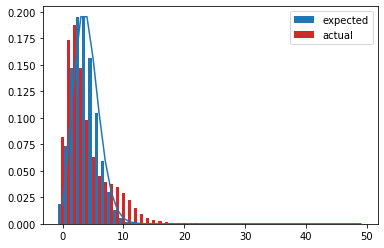

---- Sample data ----
MWU: MannwhitneyuResult(statistic=346.5, pvalue=5.5443980981032376e-11)
Levene: LeveneResult(statistic=8.514436490265112e-06, pvalue=0.9976777470724826)


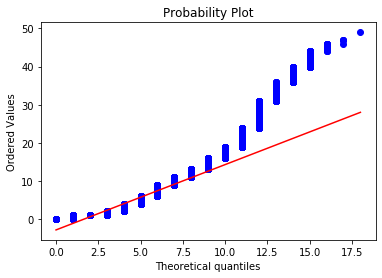

33554432
---- Normalized data ----
Mean: 3.99999737739563; expected: 4; difference: 2.6226043701171875e-06
Std: 13.631802320473465; expected: 4; difference: 9.631802320473465
difference between std and mean :9.631804943077835
MWU: MannwhitneyuResult(statistic=691.0, pvalue=4.5981178633439797e-07)
Levene: LeveneResult(statistic=7.256936032761725e-06, pvalue=0.9978555749007572)


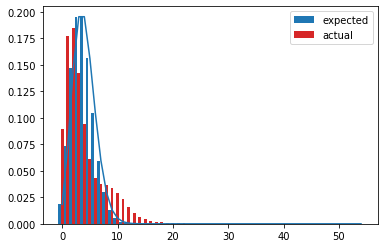

---- Sample data ----
MWU: MannwhitneyuResult(statistic=372.0, pvalue=9.328254302568977e-13)
Levene: LeveneResult(statistic=4.152812740695589e-06, pvalue=0.9983777953762346)


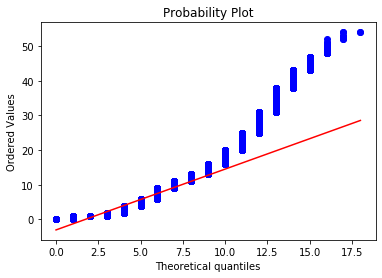

In [303]:
for N in Ns2:
    print(N)
    analize_result(occs2[N],N,plot=True,l=4)
    analize_result_2(occs2[N],plot=True,l=4)

### Computing with lambda = 32 from N=2ˆ10 up to 2ˆ26.

In [268]:
Ns3 = [2**i for i in range(10,26)]
occs3 = get_amounts_for_ns(Ns3,lamb=32)

1024
---- Normalized data ----
Mean: 31.875; expected: 32; difference: 0.125
Std: 9.109375; expected: 32; difference: 22.890625
difference between std and mean :22.765625
MWU: MannwhitneyuResult(statistic=367.0, pvalue=2.888332943803969e-05)
Levene: LeveneResult(statistic=0.16028251336312102, pvalue=0.6900197100179897)


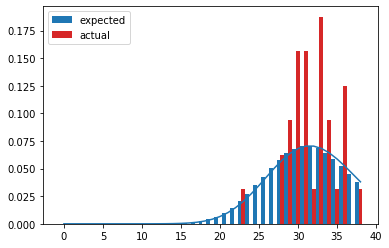

---- Sample data ----
MWU: MannwhitneyuResult(statistic=637.0, pvalue=0.03692604286208725)
Levene: LeveneResult(statistic=0.0, pvalue=1.0)


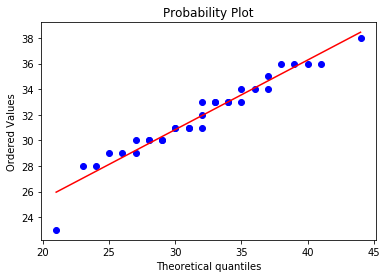

2048
---- Normalized data ----
Mean: 31.921875; expected: 32; difference: 0.078125
Std: 7.040771484375; expected: 32; difference: 24.959228515625
difference between std and mean :24.881103515625
MWU: MannwhitneyuResult(statistic=408.0, pvalue=0.00016346309968823697)
Levene: LeveneResult(statistic=0.186532574479709, pvalue=0.6670411826445173)


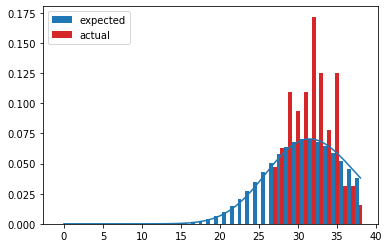

---- Sample data ----
MWU: MannwhitneyuResult(statistic=648.5, pvalue=0.06556692682609641)
Levene: LeveneResult(statistic=0.0, pvalue=1.0)


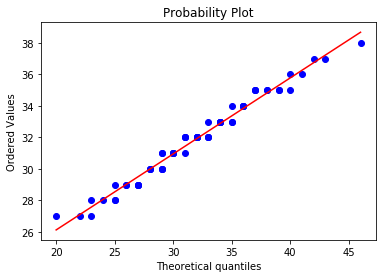

4096
---- Normalized data ----
Mean: 31.953125; expected: 32; difference: 0.046875
Std: 12.591552734375; expected: 32; difference: 19.408447265625
difference between std and mean :19.361572265625
MWU: MannwhitneyuResult(statistic=558.0, pvalue=0.004038962090780901)
Levene: LeveneResult(statistic=0.11328217219095629, pvalue=0.7373192326310609)


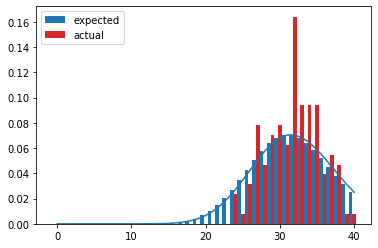

---- Sample data ----
MWU: MannwhitneyuResult(statistic=644.0, pvalue=0.011847595771103829)
Levene: LeveneResult(statistic=0.0, pvalue=1.0)


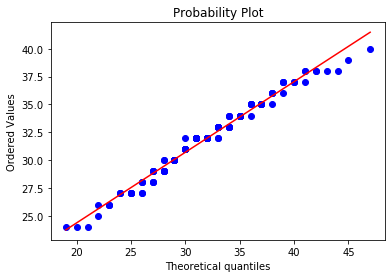

8192
---- Normalized data ----
Mean: 31.97265625; expected: 32; difference: 0.02734375
Std: 22.221908569335938; expected: 32; difference: 9.778091430664062
difference between std and mean :9.750747680664062
MWU: MannwhitneyuResult(statistic=777.0, pvalue=0.02814848918561615)
Levene: LeveneResult(statistic=0.0782114312054431, pvalue=0.7803922969250103)


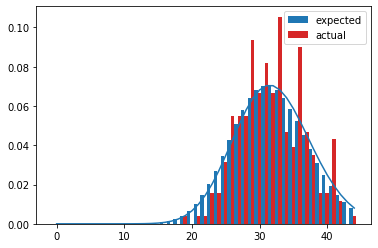

---- Sample data ----
MWU: MannwhitneyuResult(statistic=630.5, pvalue=0.00012093045191728113)
Levene: LeveneResult(statistic=0.00042295039945316326, pvalue=0.9836386153261997)


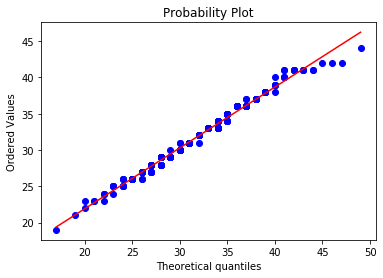

16384
---- Normalized data ----
Mean: 31.984375; expected: 32; difference: 0.015625
Std: 26.843505859375; expected: 32; difference: 5.156494140625
difference between std and mean :5.140869140625
MWU: MannwhitneyuResult(statistic=1012.0, pvalue=0.09000206721072934)
Levene: LeveneResult(statistic=0.007939759851067783, pvalue=0.9291838308550879)


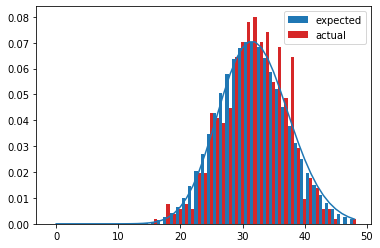

---- Sample data ----
MWU: MannwhitneyuResult(statistic=654.5, pvalue=4.295556220112678e-06)
Levene: LeveneResult(statistic=0.004269227414707818, pvalue=0.9480397048250743)


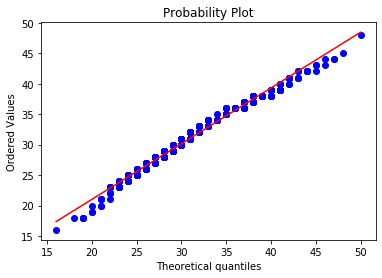

32768
---- Normalized data ----
Mean: 31.9912109375; expected: 32; difference: 0.0087890625
Std: 26.01261806488037; expected: 32; difference: 5.987381935119629
difference between std and mean :5.978592872619629
MWU: MannwhitneyuResult(statistic=1081.0, pvalue=0.12211038547332753)
Levene: LeveneResult(statistic=0.004874878395640049, pvalue=0.9444789403546455)


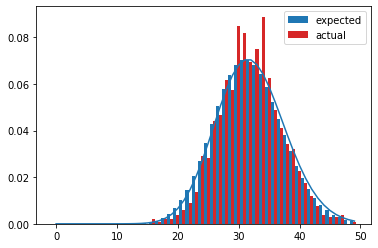

---- Sample data ----
MWU: MannwhitneyuResult(statistic=620.0, pvalue=3.9878487247155395e-07)
Levene: LeveneResult(statistic=0.00371790653478979, pvalue=0.9515035850969034)


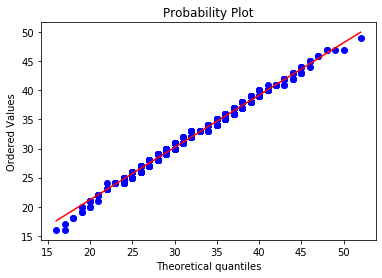

65536
---- Normalized data ----
Mean: 31.9951171875; expected: 32; difference: 0.0048828125
Std: 24.02146053314209; expected: 32; difference: 7.97853946685791
difference between std and mean :7.97365665435791
MWU: MannwhitneyuResult(statistic=1127.0, pvalue=0.12291144219612765)
Levene: LeveneResult(statistic=0.007566551125231048, pvalue=0.9308566430445193)


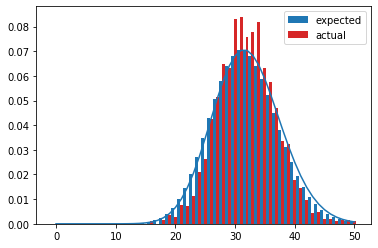

---- Sample data ----
MWU: MannwhitneyuResult(statistic=648.0, pvalue=4.2903177753805964e-07)
Levene: LeveneResult(statistic=0.0019437922564549653, pvalue=0.9649218094187682)


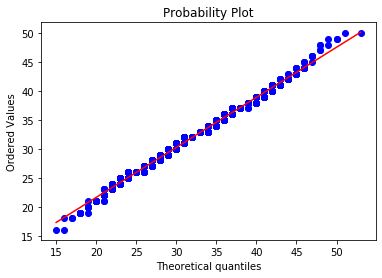

131072
---- Normalized data ----
Mean: 31.997314453125; expected: 32; difference: 0.002685546875
Std: 23.899162709712982; expected: 32; difference: 8.100837290287018
difference between std and mean :8.098151743412018
MWU: MannwhitneyuResult(statistic=1177.0, pvalue=0.12786181022667437)
Levene: LeveneResult(statistic=0.008207046648660987, pvalue=0.9279938554068192)


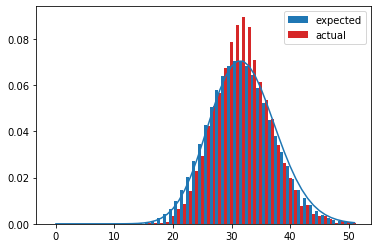

---- Sample data ----
MWU: MannwhitneyuResult(statistic=636.5, pvalue=9.800273024154187e-08)
Levene: LeveneResult(statistic=0.0010858236581561555, pvalue=0.9737773896177905)


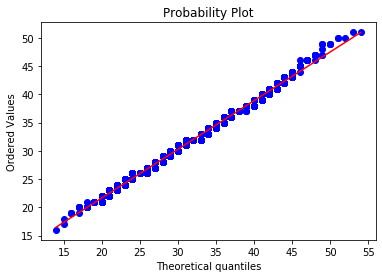

262144
---- Normalized data ----
Mean: 31.99853515625; expected: 32; difference: 0.00146484375
Std: 30.402585744857788; expected: 32; difference: 1.597414255142212
difference between std and mean :1.595949411392212
MWU: MannwhitneyuResult(statistic=1593.0, pvalue=0.21406395182500243)
Levene: LeveneResult(statistic=0.00016102803566117046, pvalue=0.9898971690691633)


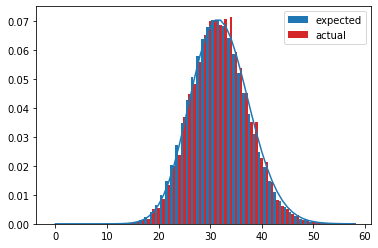

---- Sample data ----
MWU: MannwhitneyuResult(statistic=777.5, pvalue=4.1778908452512705e-09)
Levene: LeveneResult(statistic=0.0006433432483013984, pvalue=0.9798080388815319)


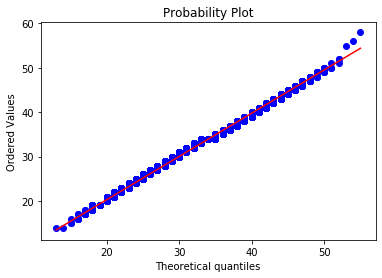

524288
---- Normalized data ----
Mean: 31.99920654296875; expected: 32; difference: 0.00079345703125
Std: 36.04132017120719; expected: 32; difference: 4.04132017120719
difference between std and mean :4.04211362823844
MWU: MannwhitneyuResult(statistic=1947.0, pvalue=0.42831720306024323)
Levene: LeveneResult(statistic=0.000935224118242488, pvalue=0.9756525158878957)


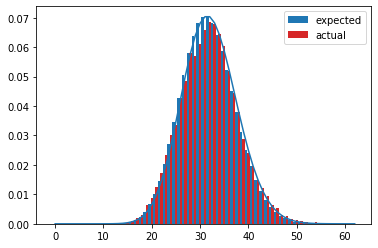

---- Sample data ----
MWU: MannwhitneyuResult(statistic=744.0, pvalue=1.495440013592817e-11)
Levene: LeveneResult(statistic=0.0009903173633123003, pvalue=0.9749458646419138)


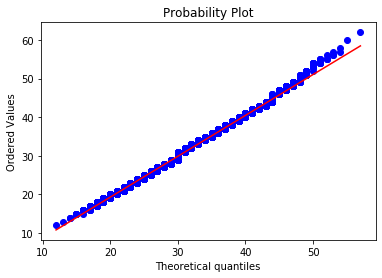

1048576
---- Normalized data ----
Mean: 31.99957275390625; expected: 32; difference: 0.00042724609375
Std: 36.777953919023275; expected: 32; difference: 4.777953919023275
difference between std and mean :4.778381165117025
MWU: MannwhitneyuResult(statistic=2091.0, pvalue=0.4610365540447827)
Levene: LeveneResult(statistic=0.0014696530233622859, pvalue=0.9694794716351689)


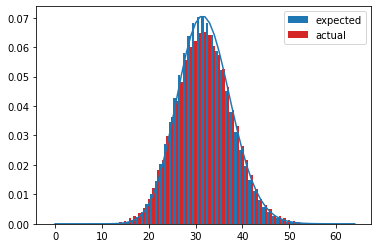

---- Sample data ----
MWU: MannwhitneyuResult(statistic=727.0, pvalue=1.6187906173298242e-12)
Levene: LeveneResult(statistic=0.0009247258501676338, pvalue=0.9757879877289304)


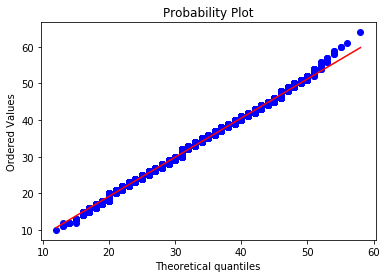

2097152
---- Normalized data ----
Mean: 31.999771118164062; expected: 32; difference: 0.0002288818359375
Std: 32.00819391733967; expected: 32; difference: 0.008193917339667678
difference between std and mean :0.008422799175605178
MWU: MannwhitneyuResult(statistic=1859.0, pvalue=0.2707569930776443)
Levene: LeveneResult(statistic=8.590311766196191e-07, pvalue=0.9992619787295945)


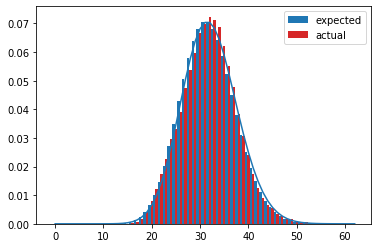

---- Sample data ----
MWU: MannwhitneyuResult(statistic=821.0, pvalue=2.2725288199185701e-10)
Levene: LeveneResult(statistic=0.00030990537550494487, pvalue=0.9859829565405427)


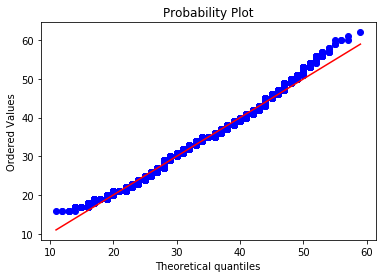

4194304
---- Normalized data ----
Mean: 31.9998779296875; expected: 32; difference: 0.0001220703125
Std: 41.036910995841026; expected: 32; difference: 9.036910995841026
difference between std and mean :9.037033066153526
MWU: MannwhitneyuResult(statistic=2021.0, pvalue=0.23812770431805402)
Levene: LeveneResult(statistic=0.004292786338064631, pvalue=0.9478611430774805)


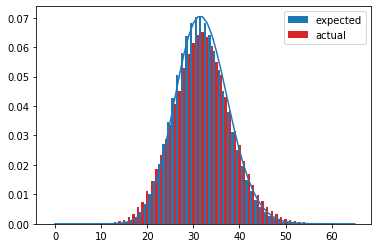

---- Sample data ----
MWU: MannwhitneyuResult(statistic=617.0, pvalue=1.8917538897168697e-14)
Levene: LeveneResult(statistic=0.0015903878640976211, pvalue=0.9682502415357892)


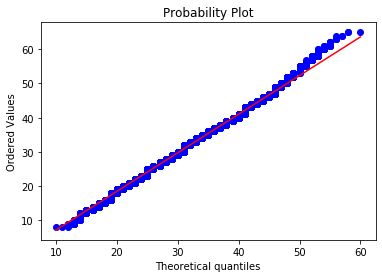

8388608
---- Normalized data ----
Mean: 31.999935150146484; expected: 32; difference: 6.4849853515625e-05
Std: 48.292713161077714; expected: 32; difference: 16.292713161077714
difference between std and mean :16.29277801093123
MWU: MannwhitneyuResult(statistic=2266.0, pvalue=0.09669651653324096)
Levene: LeveneResult(statistic=0.004950664625852556, pvalue=0.9440053573538428)


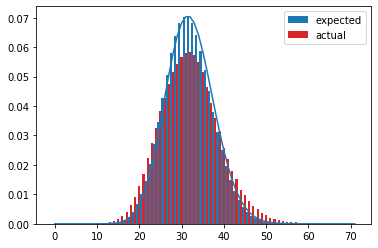

---- Sample data ----
MWU: MannwhitneyuResult(statistic=630.0, pvalue=5.868406301933317e-17)
Levene: LeveneResult(statistic=0.0012400404148157544, pvalue=0.9719583862316723)


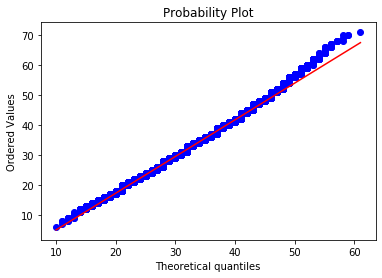

16777216
---- Normalized data ----
Mean: 31.99996566772461; expected: 32; difference: 3.4332275390625e-05
Std: 51.42560958744433; expected: 32; difference: 19.425609587444328
difference between std and mean :19.425643919719718
MWU: MannwhitneyuResult(statistic=2472.0, pvalue=0.06286511083163183)
Levene: LeveneResult(statistic=0.004315243825175546, pvalue=0.9477116934957257)


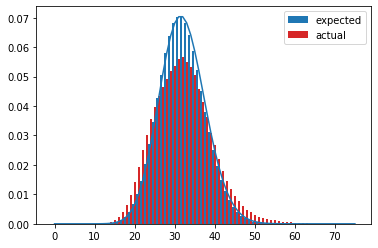

---- Sample data ----
MWU: MannwhitneyuResult(statistic=671.5, pvalue=2.8634088700385e-18)
Levene: LeveneResult(statistic=0.0009717842583500464, pvalue=0.9751726499058777)


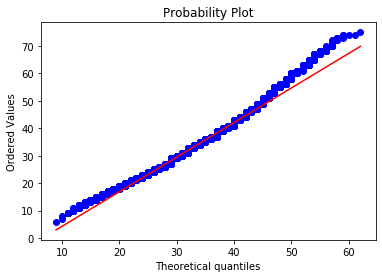

33554432
---- Normalized data ----
Mean: 31.99998188018799; expected: 32; difference: 1.811981201171875e-05
Std: 52.71373653379031; expected: 32; difference: 20.71373653379031
difference between std and mean :20.713754653602322
MWU: MannwhitneyuResult(statistic=2807.0, pvalue=0.03409822365630973)
Levene: LeveneResult(statistic=0.0018910064081134232, pvalue=0.9653679136292999)


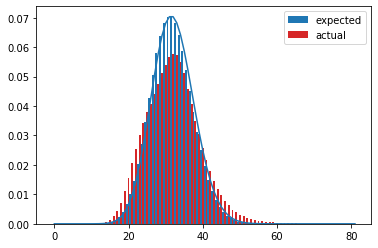

---- Sample data ----
MWU: MannwhitneyuResult(statistic=780.5, pvalue=1.288416299756937e-19)
Levene: LeveneResult(statistic=0.0004096356075235029, pvalue=0.9838772590559903)


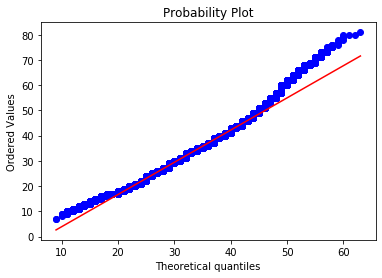

In [304]:
for N in Ns3:
    print(N)
    analize_result(occs3[N],N,plot=True,l=32)
    analize_result_2(occs3[N],plot=True,l=32)

### Champernowne with lambda = 4 from N=2ˆ10 up to 2ˆ26

In [310]:
Ns_c4 = [2**i for i in range(10,26)]
occs_c4 = get_amounts_for_ns(Ns2,lamb=4,use_levin=False)

1024
---- Normalized data ----
Mean: 3.97265625; expected: 4; difference: 0.02734375
Std: 3.8312835693359375; expected: 4; difference: 0.1687164306640625
difference between std and mean :0.1413726806640625
MWU: MannwhitneyuResult(statistic=83.0, pvalue=0.4795364004210436)
Levene: LeveneResult(statistic=0.06057092104351643, pvalue=0.807688527974126)


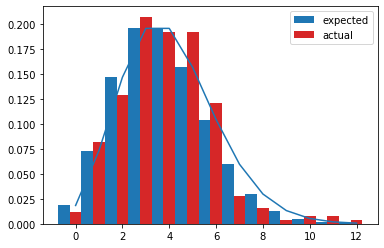

---- Sample data ----
MWU: MannwhitneyuResult(statistic=50.0, pvalue=0.03900358165636666)
Levene: LeveneResult(statistic=0.0531461478396669, pvalue=0.8196302824323345)


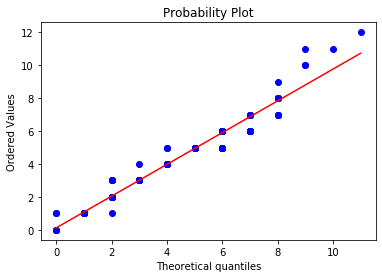

2048
---- Normalized data ----
Mean: 3.984375; expected: 4; difference: 0.015625
Std: 5.706787109375; expected: 4; difference: 1.706787109375
difference between std and mean :1.722412109375
MWU: MannwhitneyuResult(statistic=130.0, pvalue=0.31475003399766704)
Levene: LeveneResult(statistic=0.01946761667567792, pvalue=0.8899086644109994)


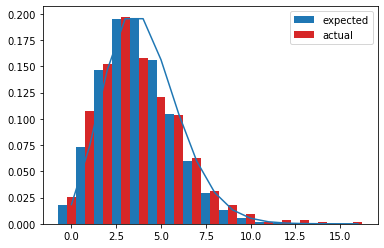

---- Sample data ----
MWU: MannwhitneyuResult(statistic=80.5, pvalue=0.012627807069794987)
Levene: LeveneResult(statistic=0.03766970826211889, pvalue=0.8473347326519634)


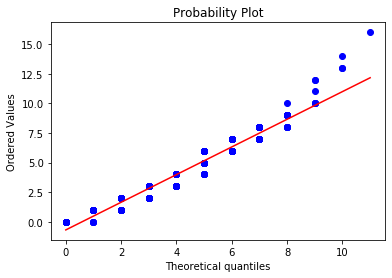

4096
---- Normalized data ----
Mean: 3.9912109375; expected: 4; difference: 0.0087890625
Std: 8.006758689880371; expected: 4; difference: 4.006758689880371
difference between std and mean :4.015547752380371
MWU: MannwhitneyuResult(statistic=191.0, pvalue=0.23279770605455818)
Levene: LeveneResult(statistic=0.017646232628812004, pvalue=0.8949866422193873)


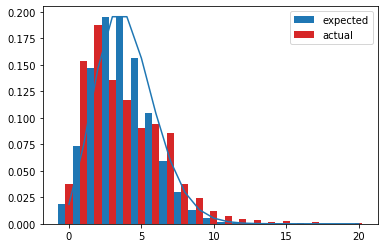

---- Sample data ----
MWU: MannwhitneyuResult(statistic=109.0, pvalue=0.002028743032707537)
Levene: LeveneResult(statistic=0.01178086667602384, pvalue=0.9141102460314071)


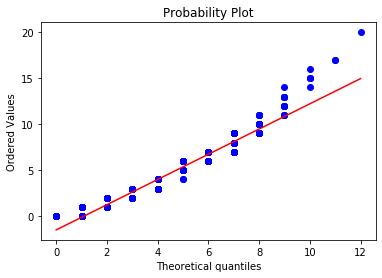

8192
---- Normalized data ----
Mean: 3.9951171875; expected: 4; difference: 0.0048828125
Std: 9.10935115814209; expected: 4; difference: 5.10935115814209
difference between std and mean :5.11423397064209
MWU: MannwhitneyuResult(statistic=122.0, pvalue=0.22428069143091445)
Levene: LeveneResult(statistic=0.19958706442483265, pvalue=0.6580633674272556)


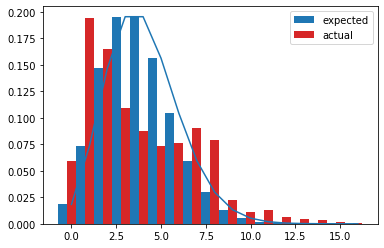

---- Sample data ----
MWU: MannwhitneyuResult(statistic=68.5, pvalue=0.004217964302237853)
Levene: LeveneResult(statistic=0.1259032143711013, pvalue=0.7250460634384241)


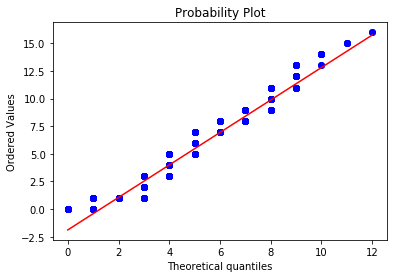

16384
---- Normalized data ----
Mean: 3.997314453125; expected: 4; difference: 0.002685546875
Std: 9.672111928462982; expected: 4; difference: 5.672111928462982
difference between std and mean :5.674797475337982
MWU: MannwhitneyuResult(statistic=171.0, pvalue=0.10882871899210733)
Levene: LeveneResult(statistic=0.03023552937873271, pvalue=0.8628339305273)


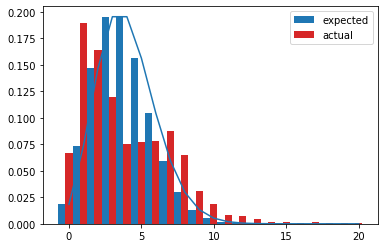

---- Sample data ----
MWU: MannwhitneyuResult(statistic=92.0, pvalue=0.0005398181249765872)
Levene: LeveneResult(statistic=0.017801213960055826, pvalue=0.8945292856049352)


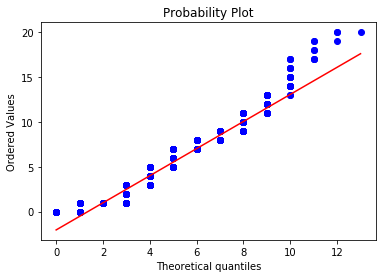

32768
---- Normalized data ----
Mean: 3.99853515625; expected: 4; difference: 0.00146484375
Std: 10.803464651107788; expected: 4; difference: 6.803464651107788
difference between std and mean :6.804929494857788
MWU: MannwhitneyuResult(statistic=234.0, pvalue=0.029082236383509822)
Levene: LeveneResult(statistic=0.007216590878810906, pvalue=0.9326399719414831)


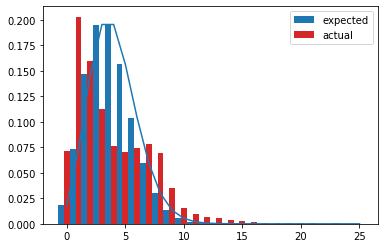

---- Sample data ----
MWU: MannwhitneyuResult(statistic=125.0, pvalue=3.331137878585164e-05)
Levene: LeveneResult(statistic=0.0037851307393466267, pvalue=0.9511876408597415)


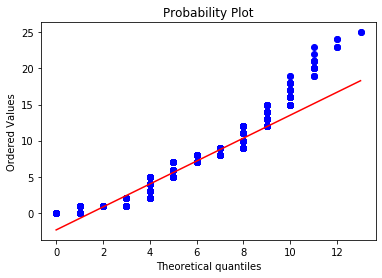

65536
---- Normalized data ----
Mean: 3.99920654296875; expected: 4; difference: 0.00079345703125
Std: 11.84649595245719; expected: 4; difference: 7.84649595245719
difference between std and mean :7.84728940948844
MWU: MannwhitneyuResult(statistic=305.0, pvalue=0.00687042756425226)
Levene: LeveneResult(statistic=0.0019396088615250338, pvalue=0.9650179745518496)


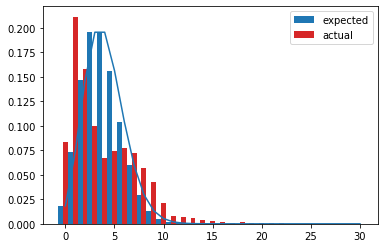

---- Sample data ----
MWU: MannwhitneyuResult(statistic=158.0, pvalue=1.627814640083226e-06)
Levene: LeveneResult(statistic=0.0010265333353761208, pvalue=0.9745468476055728)


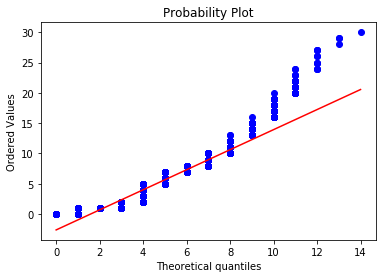

131072
---- Normalized data ----
Mean: 3.99957275390625; expected: 4; difference: 0.00042724609375
Std: 14.135986145585775; expected: 4; difference: 10.135986145585775
difference between std and mean :10.136413391679525
MWU: MannwhitneyuResult(statistic=386.0, pvalue=0.0006366472379299044)
Levene: LeveneResult(statistic=0.0007320914147243734, pvalue=0.9784889764245555)


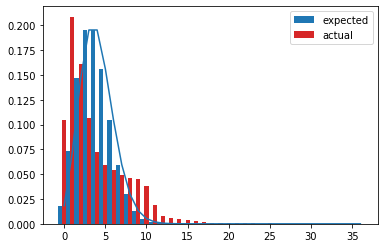

---- Sample data ----
MWU: MannwhitneyuResult(statistic=200.0, pvalue=3.3723742325548526e-08)
Levene: LeveneResult(statistic=0.00040011049180488367, pvalue=0.9840964986342984)


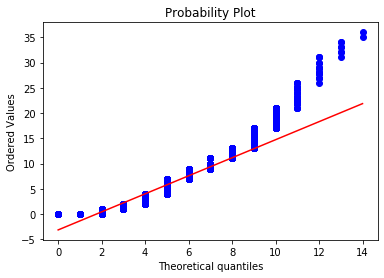

262144
---- Normalized data ----
Mean: 3.9997711181640625; expected: 4; difference: 0.0002288818359375
Std: 16.531997628277168; expected: 4; difference: 12.531997628277168
difference between std and mean :12.532226510113105
MWU: MannwhitneyuResult(statistic=468.0, pvalue=4.097310678168689e-05)
Levene: LeveneResult(statistic=0.00039489928372222685, pvalue=0.9841925506591248)


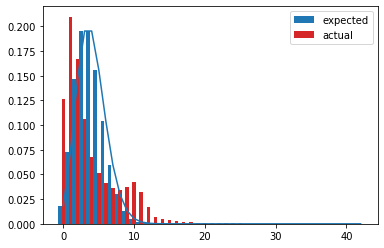

---- Sample data ----
MWU: MannwhitneyuResult(statistic=253.5, pvalue=1.0057994517976455e-09)
Levene: LeveneResult(statistic=0.0002200145758070372, pvalue=0.9882006750639799)


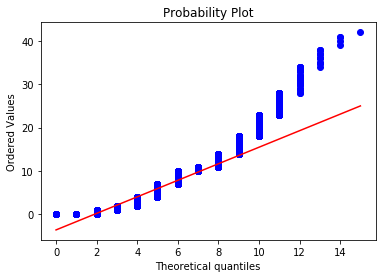

524288
---- Normalized data ----
Mean: 3.9998779296875; expected: 4; difference: 0.0001220703125
Std: 19.141754135489464; expected: 4; difference: 15.141754135489464
difference between std and mean :15.141876205801964
MWU: MannwhitneyuResult(statistic=642.0, pvalue=1.4058992489761387e-05)
Levene: LeveneResult(statistic=0.00016498870890067335, pvalue=0.9897777326624936)


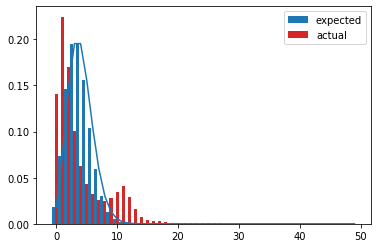

---- Sample data ----
MWU: MannwhitneyuResult(statistic=346.5, pvalue=4.326063517303224e-11)
Levene: LeveneResult(statistic=9.508241420185052e-05, pvalue=0.9922397567584207)


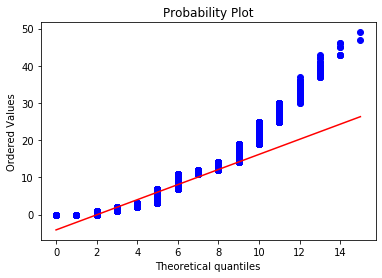

1048576
---- Normalized data ----
Mean: 3.9999351501464844; expected: 4; difference: 6.4849853515625e-05
Std: 22.34499740180036; expected: 4; difference: 18.34499740180036
difference between std and mean :18.345062251653875
MWU: MannwhitneyuResult(statistic=761.0, pvalue=5.018460922675953e-07)
Levene: LeveneResult(statistic=6.731726167969261e-05, pvalue=0.9934682587565052)


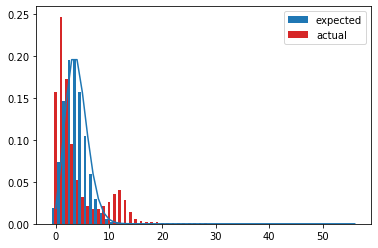

---- Sample data ----
MWU: MannwhitneyuResult(statistic=411.5, pvalue=3.977914995053687e-13)
Levene: LeveneResult(statistic=3.992593480254063e-05, pvalue=0.994969683652696)


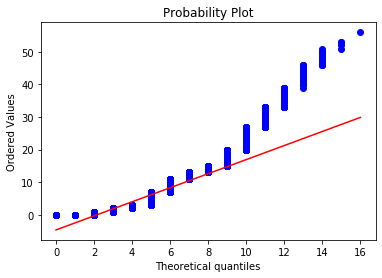

2097152
---- Normalized data ----
Mean: 3.9999656677246094; expected: 4; difference: 3.4332275390625e-05
Std: 26.04090118290333; expected: 4; difference: 22.04090118290333
difference between std and mean :22.04093551517872
MWU: MannwhitneyuResult(statistic=1003.0, pvalue=1.208548977489501e-07)
Levene: LeveneResult(statistic=2.707764279114165e-05, pvalue=0.9958562333502194)


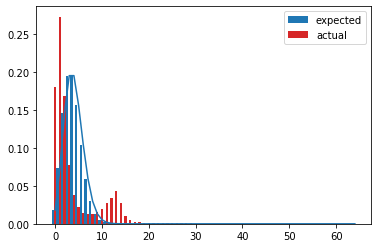

---- Sample data ----
MWU: MannwhitneyuResult(statistic=540.0, pvalue=6.363694896012101e-15)
Levene: LeveneResult(statistic=1.6599129309219912e-05, pvalue=0.9967556082976207)


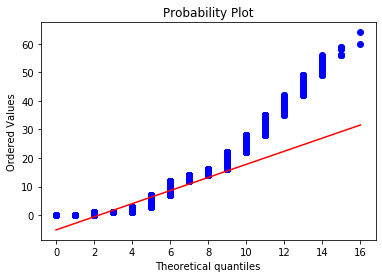

4194304
---- Normalized data ----
Mean: 3.9999818801879883; expected: 4; difference: 1.811981201171875e-05
Std: 29.155703544288375; expected: 4; difference: 25.155703544288375
difference between std and mean :25.155721664100387
MWU: MannwhitneyuResult(statistic=687.0, pvalue=5.473004581549539e-08)
Levene: LeveneResult(statistic=8.388275950358322e-05, pvalue=0.9927087683614584)


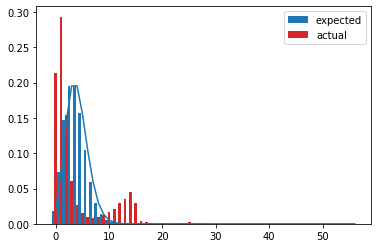

---- Sample data ----
MWU: MannwhitneyuResult(statistic=365.0, pvalue=6.860303598799348e-14)
Levene: LeveneResult(statistic=5.232996152079338e-05, pvalue=0.9942410666389971)


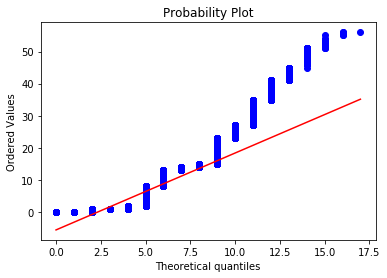

8388608
---- Normalized data ----
Mean: 3.999990463256836; expected: 4; difference: 9.5367431640625e-06
Std: 29.798016548065778; expected: 4; difference: 25.798016548065778
difference between std and mean :25.798026084808942
MWU: MannwhitneyuResult(statistic=818.0, pvalue=8.43538491541779e-10)
Levene: LeveneResult(statistic=2.9123150952092825e-05, pvalue=0.9957025691736073)


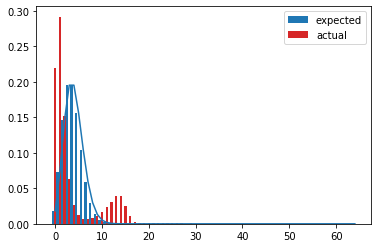

---- Sample data ----
MWU: MannwhitneyuResult(statistic=440.0, pvalue=3.227499650220037e-16)
Levene: LeveneResult(statistic=1.831254560609022e-05, pvalue=0.9965922724734261)


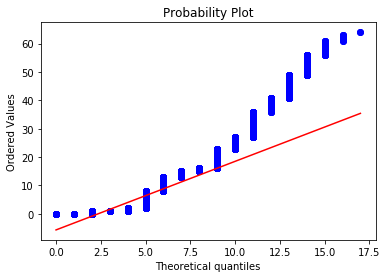

16777216
---- Normalized data ----
Mean: 3.999994993209839; expected: 4; difference: 5.0067901611328125e-06
Std: 30.987214326833445; expected: 4; difference: 26.987214326833445
difference between std and mean :26.987219333623607
MWU: MannwhitneyuResult(statistic=945.0, pvalue=8.5987885506602e-12)
Levene: LeveneResult(statistic=1.9449796614800796e-05, pvalue=0.9964872907967199)


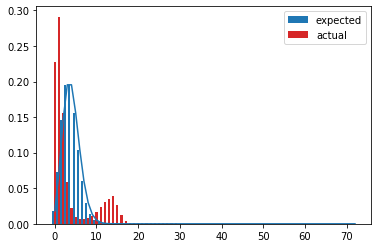

---- Sample data ----
MWU: MannwhitneyuResult(statistic=501.5, pvalue=5.435837718062367e-19)
Levene: LeveneResult(statistic=1.2344201609457596e-05, pvalue=0.997201555568661)


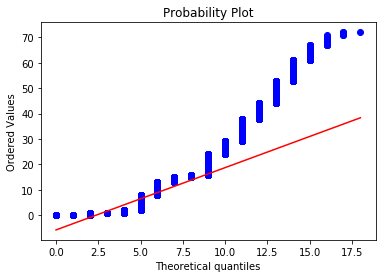

33554432
---- Normalized data ----
Mean: 3.99999737739563; expected: 4; difference: 2.6226043701171875e-06
Std: 32.46257686614302; expected: 4; difference: 28.462576866143017
difference between std and mean :28.462579488747387
MWU: MannwhitneyuResult(statistic=1092.0, pvalue=4.199561603612497e-14)
Levene: LeveneResult(statistic=9.28106868997029e-06, pvalue=0.9975730089444522)


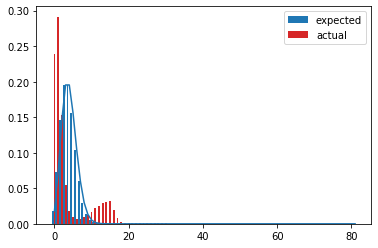

---- Sample data ----
MWU: MannwhitneyuResult(statistic=580.5, pvalue=7.04897855478709e-22)
Levene: LeveneResult(statistic=5.934553751482584e-06, pvalue=0.9980592774159094)


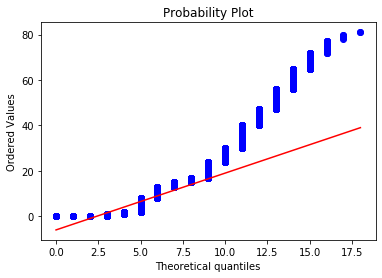

In [314]:
for N in Ns_c4:
    print(N)
    analize_result(occs_c4[N],N,plot=True,l=4)
    analize_result_2(occs_c4[N],plot=True,l=4)

### Champernowne with lambda = 1 from N=2ˆ10 up to 2ˆ26


In [315]:
Ns_c1 = [2**i for i in range(10,26)]
occs_c1 = get_amounts_for_ns(Ns2,lamb=1,use_levin=False)

1024
---- Normalized data ----
Mean: 0.9912109375; expected: 1; difference: 0.0087890625
Std: 0.9637899398803711; expected: 1; difference: 0.036210060119628906
difference between std and mean :0.027420997619628906
MWU: MannwhitneyuResult(statistic=24.0, pvalue=0.5)
Levene: LeveneResult(statistic=1.0698708591528496e-05, pvalue=0.9974439609377667)


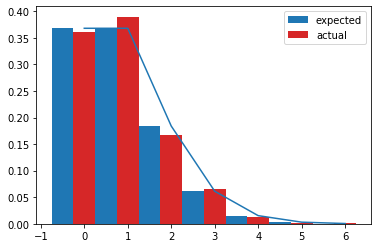

---- Sample data ----
MWU: MannwhitneyuResult(statistic=24.0, pvalue=0.5)
Levene: LeveneResult(statistic=0.00011013668697097927, pvalue=0.9917991283627486)


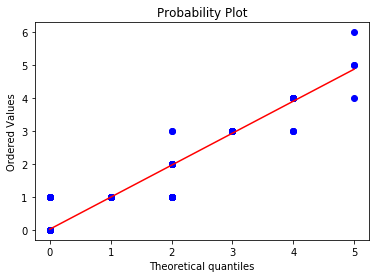

2048
---- Normalized data ----
Mean: 0.9951171875; expected: 1; difference: 0.0048828125
Std: 1.2148199081420898; expected: 1; difference: 0.21481990814208984
difference between std and mean :0.21970272064208984
MWU: MannwhitneyuResult(statistic=47.0, pvalue=0.42499762424381904)
Levene: LeveneResult(statistic=0.0001639674369567115, pvalue=0.9899242458612219)


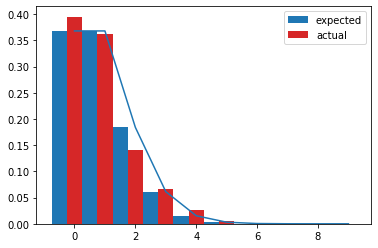

---- Sample data ----
MWU: MannwhitneyuResult(statistic=42.0, pvalue=0.28383840523588394)
Levene: LeveneResult(statistic=0.00014677010221671164, pvalue=0.9904672353771736)


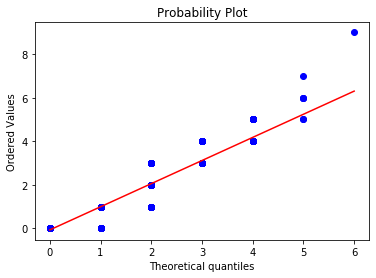

4096
---- Normalized data ----
Mean: 0.997314453125; expected: 1; difference: 0.002685546875
Std: 1.5710377097129822; expected: 1; difference: 0.5710377097129822
difference between std and mean :0.5737232565879822
MWU: MannwhitneyuResult(statistic=75.0, pvalue=0.32212122192374565)
Levene: LeveneResult(statistic=0.0001544030682276763, pvalue=0.9901885365934217)


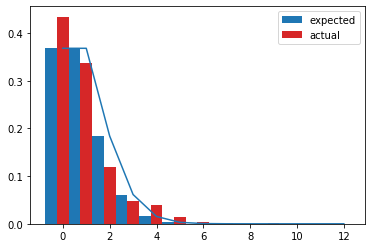

---- Sample data ----
MWU: MannwhitneyuResult(statistic=67.0, pvalue=0.18662387135503128)
Levene: LeveneResult(statistic=0.00017782529138620602, pvalue=0.9894706678968009)


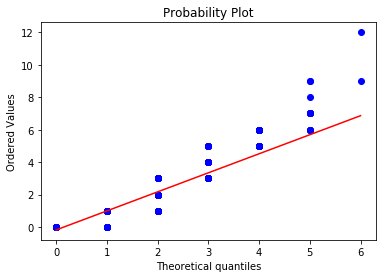

8192
---- Normalized data ----
Mean: 0.99853515625; expected: 1; difference: 0.00146484375
Std: 1.876950979232788; expected: 1; difference: 0.8769509792327881
difference between std and mean :0.8784158229827881
MWU: MannwhitneyuResult(statistic=41.0, pvalue=0.2601830104482655)
Levene: LeveneResult(statistic=0.012594656726337753, pvalue=0.9118863424985811)


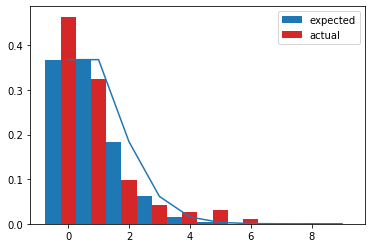

---- Sample data ----
MWU: MannwhitneyuResult(statistic=40.0, pvalue=0.23600427883305353)
Levene: LeveneResult(statistic=0.012694878813457764, pvalue=0.9115380109091266)


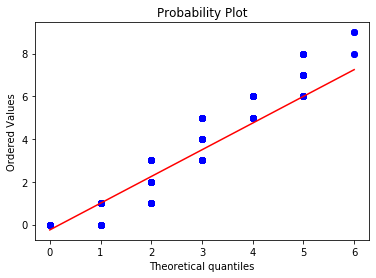

16384
---- Normalized data ----
Mean: 0.99920654296875; expected: 1; difference: 0.00079345703125
Std: 1.9963982962071896; expected: 1; difference: 0.9963982962071896
difference between std and mean :0.9971917532384396
MWU: MannwhitneyuResult(statistic=61.0, pvalue=0.11902185854256181)
Levene: LeveneResult(statistic=0.00117377645873766, pvalue=0.9729528398748535)


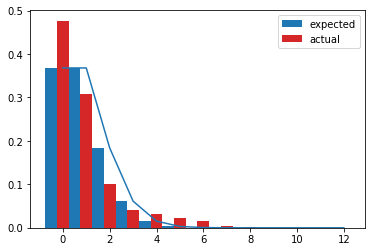

---- Sample data ----
MWU: MannwhitneyuResult(statistic=60.5, pvalue=0.11259866058489898)
Levene: LeveneResult(statistic=0.001197457833199919, pvalue=0.972681471404995)


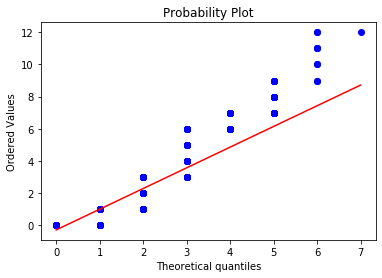

32768
---- Normalized data ----
Mean: 0.99957275390625; expected: 1; difference: 0.00042724609375
Std: 2.1852415166795254; expected: 1; difference: 1.1852415166795254
difference between std and mean :1.1856687627732754
MWU: MannwhitneyuResult(statistic=91.0, pvalue=0.03393072617650289)
Levene: LeveneResult(statistic=3.1247750960218544e-05, pvalue=0.9955745775231563)


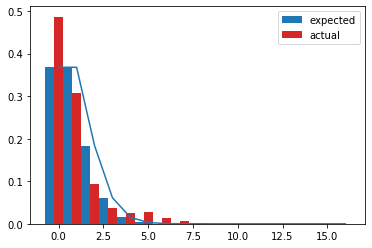

---- Sample data ----
MWU: MannwhitneyuResult(statistic=90.0, pvalue=0.03019260489622316)
Levene: LeveneResult(statistic=3.153568972696508e-05, pvalue=0.9955542350202032)


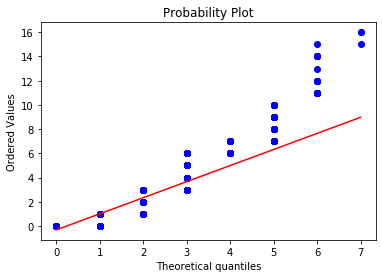

65536
---- Normalized data ----
Mean: 0.9997711181640625; expected: 1; difference: 0.0002288818359375
Std: 2.3702849817927927; expected: 1; difference: 1.3702849817927927
difference between std and mean :1.3705138636287302
MWU: MannwhitneyuResult(statistic=123.0, pvalue=0.00733342544780033)
Levene: LeveneResult(statistic=7.167880912292756e-06, pvalue=0.9978771424034737)


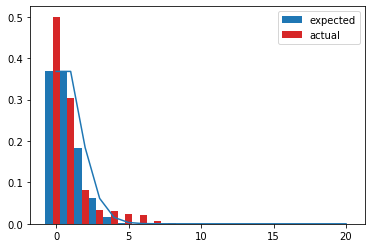

---- Sample data ----
MWU: MannwhitneyuResult(statistic=118.0, pvalue=0.004590536790179613)
Levene: LeveneResult(statistic=7.178364160576772e-06, pvalue=0.9978755906017757)


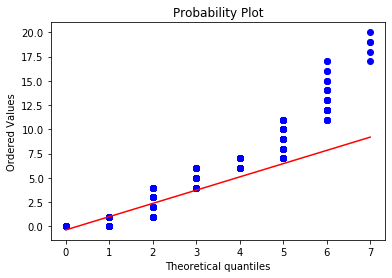

131072
---- Normalized data ----
Mean: 0.9998779296875; expected: 1; difference: 0.0001220703125
Std: 2.782562240958214; expected: 1; difference: 1.7825622409582138
difference between std and mean :1.7826843112707138
MWU: MannwhitneyuResult(statistic=162.0, pvalue=0.0006573522529824548)
Levene: LeveneResult(statistic=2.0574759680260487e-06, pvalue=0.9988612301309084)


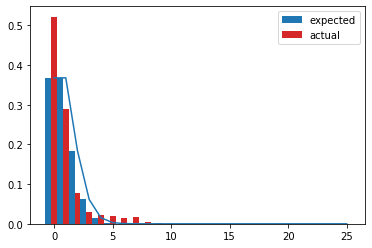

---- Sample data ----
MWU: MannwhitneyuResult(statistic=162.5, pvalue=0.0005538316090574928)
Levene: LeveneResult(statistic=2.0555572793763948e-06, pvalue=0.9988617612310883)


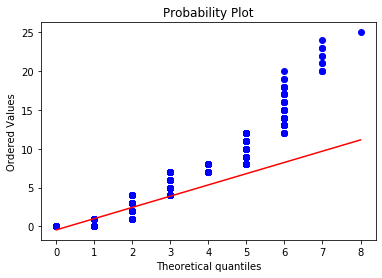

262144
---- Normalized data ----
Mean: 0.9999351501464844; expected: 1; difference: 6.4849853515625e-05
Std: 3.2263755756284818; expected: 1; difference: 2.2263755756284818
difference between std and mean :2.2264404254819974
MWU: MannwhitneyuResult(statistic=203.0, pvalue=4.806501554569991e-05)
Levene: LeveneResult(statistic=1.095010218297123e-06, pvalue=0.9991685433884085)


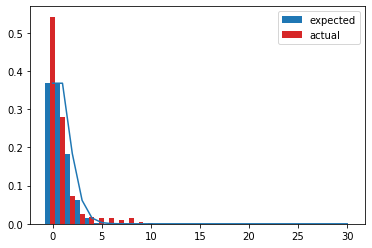

---- Sample data ----
MWU: MannwhitneyuResult(statistic=204.5, pvalue=3.795730643150767e-05)
Levene: LeveneResult(statistic=1.0935727319092753e-06, pvalue=0.9991690893206571)


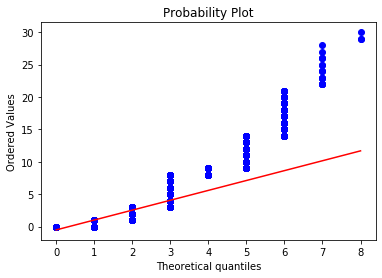

524288
---- Normalized data ----
Mean: 0.9999656677246094; expected: 1; difference: 3.4332275390625e-05
Std: 3.7450866687431694; expected: 1; difference: 2.7450866687431694
difference between std and mean :2.74512100101856
MWU: MannwhitneyuResult(statistic=310.0, pvalue=2.6297885140884486e-05)
Levene: LeveneResult(statistic=4.5570802034371344e-07, pvalue=0.9994632458083925)


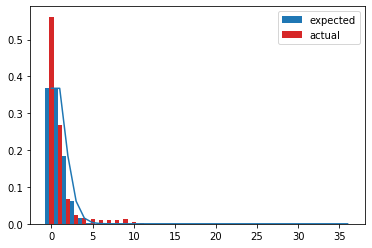

---- Sample data ----
MWU: MannwhitneyuResult(statistic=280.0, pvalue=3.3009813381174734e-06)
Levene: LeveneResult(statistic=4.561194325391503e-07, pvalue=0.9994630035665368)


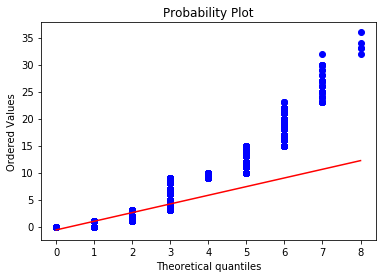

1048576
---- Normalized data ----
Mean: 0.9999818801879883; expected: 1; difference: 1.811981201171875e-05
Std: 4.38926982846806; expected: 1; difference: 3.38926982846806
difference between std and mean :3.3892879482800717
MWU: MannwhitneyuResult(statistic=376.0, pvalue=1.1041547957272305e-06)
Levene: LeveneResult(statistic=2.6215551264870583e-07, pvalue=0.9995926881722259)


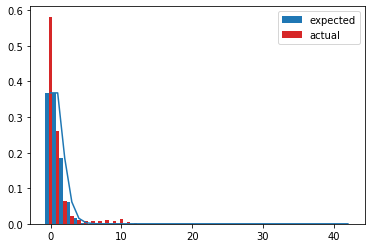

---- Sample data ----
MWU: MannwhitneyuResult(statistic=340.0, pvalue=8.780505196083263e-08)
Levene: LeveneResult(statistic=2.6225978454003663e-07, pvalue=0.9995926071687178)


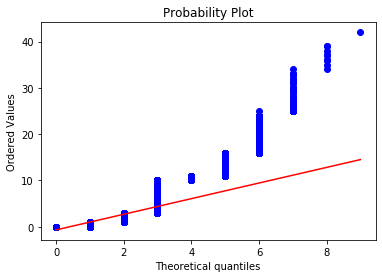

2097152
---- Normalized data ----
Mean: 0.9999904632568359; expected: 1; difference: 9.5367431640625e-06
Std: 5.1826639174505535; expected: 1; difference: 4.1826639174505535
difference between std and mean :4.182673454193718
MWU: MannwhitneyuResult(statistic=533.0, pvalue=3.910287901172046e-07)
Levene: LeveneResult(statistic=1.0011267521635185e-07, pvalue=0.9997481878404344)


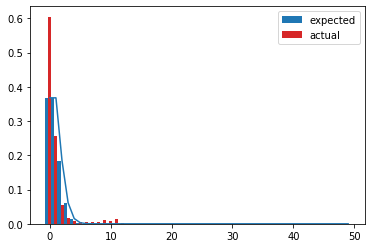

---- Sample data ----
MWU: MannwhitneyuResult(statistic=453.0, pvalue=4.7033538047599904e-09)
Levene: LeveneResult(statistic=1.0011536633777113e-07, pvalue=0.9997481844332914)


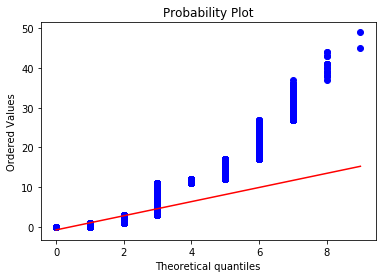

4194304
---- Normalized data ----
Mean: 0.9999949932098389; expected: 1; difference: 5.0067901611328125e-06
Std: 5.982516050313675; expected: 1; difference: 4.982516050313675
difference between std and mean :4.9825210571038365
MWU: MannwhitneyuResult(statistic=306.0, pvalue=4.700470884890722e-08)
Levene: LeveneResult(statistic=4.482743174850384e-07, pvalue=0.9994673775749704)


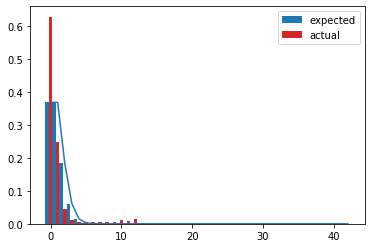

---- Sample data ----
MWU: MannwhitneyuResult(statistic=307.0, pvalue=2.0509265503535895e-08)
Levene: LeveneResult(statistic=4.4828215799892827e-07, pvalue=0.9994673729266601)


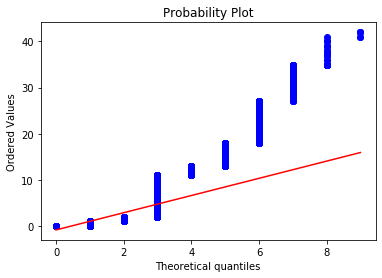

8388608
---- Normalized data ----
Mean: 0.9999973773956299; expected: 1; difference: 2.6226043701171875e-06
Std: 6.208072900765218; expected: 1; difference: 5.208072900765218
difference between std and mean :5.208075523369588
MWU: MannwhitneyuResult(statistic=372.0, pvalue=7.261149324117785e-10)
Levene: LeveneResult(statistic=9.324229774497105e-08, pvalue=0.9997569818890457)


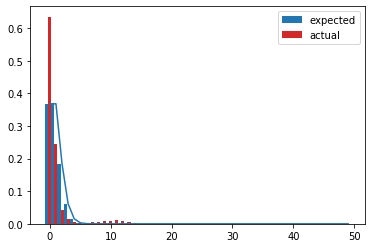

---- Sample data ----
MWU: MannwhitneyuResult(statistic=367.5, pvalue=1.8133677067310473e-10)
Levene: LeveneResult(statistic=9.322573243107595e-08, pvalue=0.999757003455587)


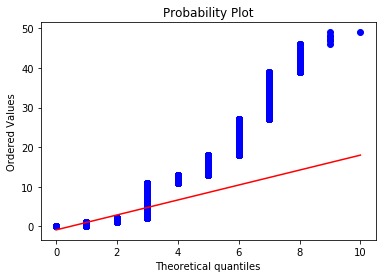

16777216
---- Normalized data ----
Mean: 0.9999986290931702; expected: 1; difference: 1.3709068298339844e-06
Std: 6.497563064096477; expected: 1; difference: 5.497563064096477
difference between std and mean :5.497564435003307
MWU: MannwhitneyuResult(statistic=436.0, pvalue=8.327000745722046e-12)
Levene: LeveneResult(statistic=5.485746811798489e-08, pvalue=0.9998135387832634)


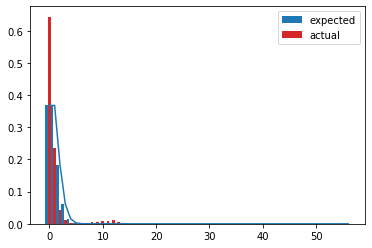

---- Sample data ----
MWU: MannwhitneyuResult(statistic=438.0, pvalue=1.9877215994225375e-12)
Levene: LeveneResult(statistic=5.485559158967322e-08, pvalue=0.9998135419531667)


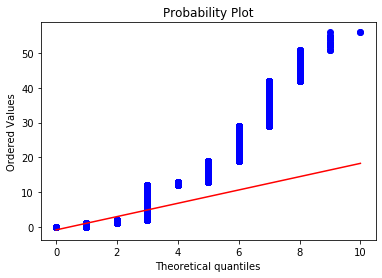

33554432
---- Normalized data ----
Mean: 0.9999992847442627; expected: 1; difference: 7.152557373046875e-07
Std: 6.846365749835456; expected: 1; difference: 5.846365749835456
difference between std and mean :5.846366465091194
MWU: MannwhitneyuResult(statistic=515.0, pvalue=5.182194125894168e-14)
Levene: LeveneResult(statistic=3.034923181833937e-08, pvalue=0.9998612714790263)


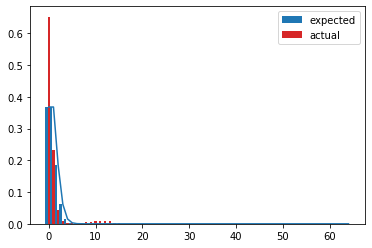

---- Sample data ----
MWU: MannwhitneyuResult(statistic=512.0, pvalue=5.279585438459663e-15)
Levene: LeveneResult(statistic=3.0349979750372056e-08, pvalue=0.9998612697901073)


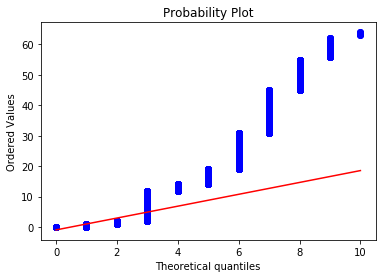

In [316]:
for N in Ns_c1:
    print(N)
    analize_result(occs_c1[N],N,plot=True,l=1)
    analize_result_2(occs_c1[N],plot=True,l=1)